# Comprehensive EDA: Ames Housing Prices Dataset

This notebook performs thorough Exploratory Data Analysis (EDA) for the Ames Housing Prices dataset. Each section includes visualizations and detailed guides on how to interpret the plots.


## Setup and Data Loading


In [226]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set seaborn style
sns.set_style("whitegrid")
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv("data/train.csv")

print(f"Dataset shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Number of observations: {df.shape[0]}")

Dataset shape: (1460, 81)
Number of features: 80
Number of observations: 1460


---

# SECTION 1 — TARGET VARIABLE ANALYSIS

## 1. Distribution of SalePrice (Raw)


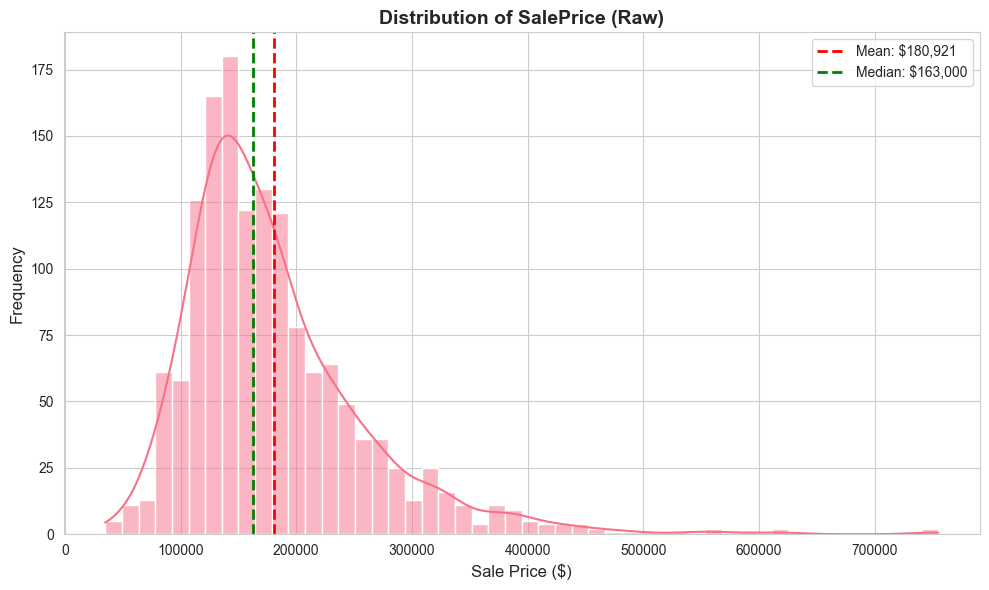


Skewness: 1.88
Mean: $180,921.20
Median: $163,000.00


In [227]:
# Create histogram with KDE for raw SalePrice
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
sns.histplot(df['SalePrice'], kde=True, bins=50, ax=ax)
ax.set_title('Distribution of SalePrice (Raw)', fontsize=14, fontweight='bold')
ax.set_xlabel('Sale Price ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Add statistics
mean_price = df['SalePrice'].mean()
median_price = df['SalePrice'].median()
ax.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_price:,.0f}')
ax.axvline(median_price, color='green', linestyle='--', linewidth=2, label=f'Median: ${median_price:,.0f}')
ax.legend()

plt.tight_layout()
plt.show()

# Calculate skewness
skewness = df['SalePrice'].skew()
print(f"\nSkewness: {skewness:.2f}")
print(f"Mean: ${mean_price:,.2f}")
print(f"Median: ${median_price:,.2f}")


From mean > median, skewness > 1, and the long tail on the right: Sale price is right skewed. This is a problem because right skewed distributions violate some assumptions of linear models (normality homoscedasticity)

Lets try a log tansformation and see if Sale Price takes a more "normal" shape


## 2. Distribution of Log(SalePrice)


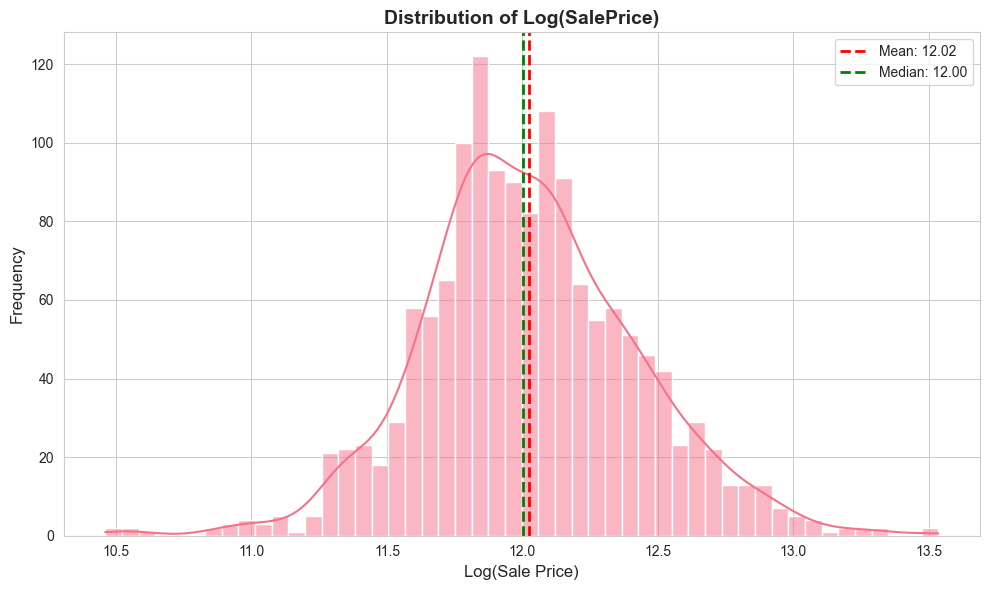


Skewness (after log transform): 0.12
Mean: 12.02
Median: 12.00


In [228]:
# Create log-transformed SalePrice
df['LogSalePrice'] = np.log1p(df['SalePrice'])

# Create histogram with KDE for log-transformed SalePrice
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df['LogSalePrice'], kde=True, bins=50, ax=ax)
ax.set_title('Distribution of Log(SalePrice)', fontsize=14, fontweight='bold')
ax.set_xlabel('Log(Sale Price)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Add statistics
mean_log = df['LogSalePrice'].mean()
median_log = df['LogSalePrice'].median()
ax.axvline(mean_log, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_log:.2f}')
ax.axvline(median_log, color='green', linestyle='--', linewidth=2, label=f'Median: {median_log:.2f}')
ax.legend()

plt.tight_layout()
plt.show()

# Calculate skewness after transformation
skewness_log = df['LogSalePrice'].skew()
print(f"\nSkewness (after log transform): {skewness_log:.2f}")
print(f"Mean: {mean_log:.2f}")
print(f"Median: {median_log:.2f}")


This looks much better from the eye test and also:
- mean≈median
- skewness is much smaller

When training models we should use a log transformed 

## 3. Boxplot of SalePrice


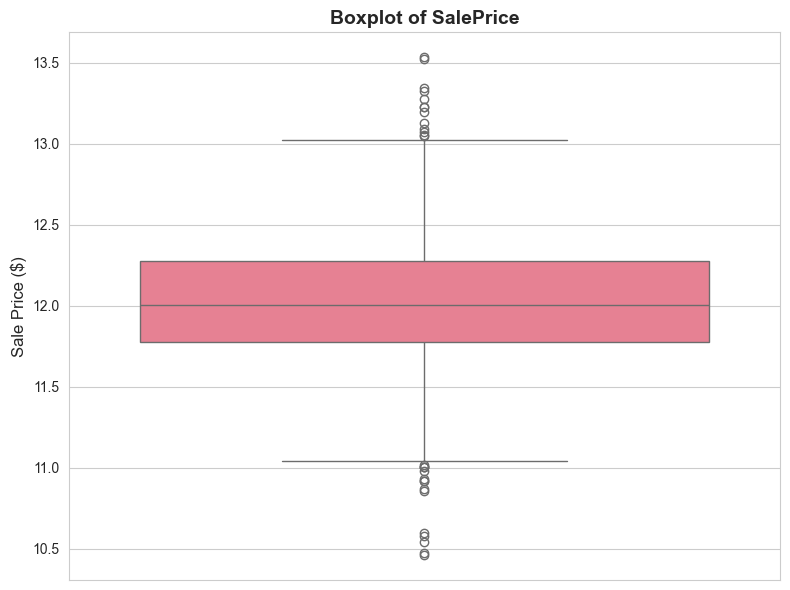


Outlier Statistics:
Q1 (25th percentile): $11.78
Q3 (75th percentile): $12.27
IQR: $0.50
Lower bound: $11.03
Upper bound: $13.02

Number of outliers: 28 (1.92%)


In [229]:
# Create boxplot for SalePrice
fig, ax = plt.subplots(figsize=(8, 6))

sns.boxplot(y=df['LogSalePrice'], ax=ax)
ax.set_title('Boxplot of SalePrice', fontsize=14, fontweight='bold')
ax.set_ylabel('Sale Price ($)', fontsize=12)

plt.tight_layout()
plt.show()

# Calculate outlier statistics
Q1 = df['LogSalePrice'].quantile(0.25)
Q3 = df['LogSalePrice'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['LogSalePrice'] < lower_bound) | (df['LogSalePrice'] > upper_bound)]
print(f"\nOutlier Statistics:")
print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")
print(f"\nNumber of outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")


Seems like we have a lot of high outliers here but we shouldn't necesarily delete them because:
- our plan to use a log trasformation will make this not matter so much
- for more robust models (random forest, XGBoost) outliers don't affect performance as much

---

# SECTION 2 — MISSING VALUE EXPLORATION

## 4. Missingness Heatmap


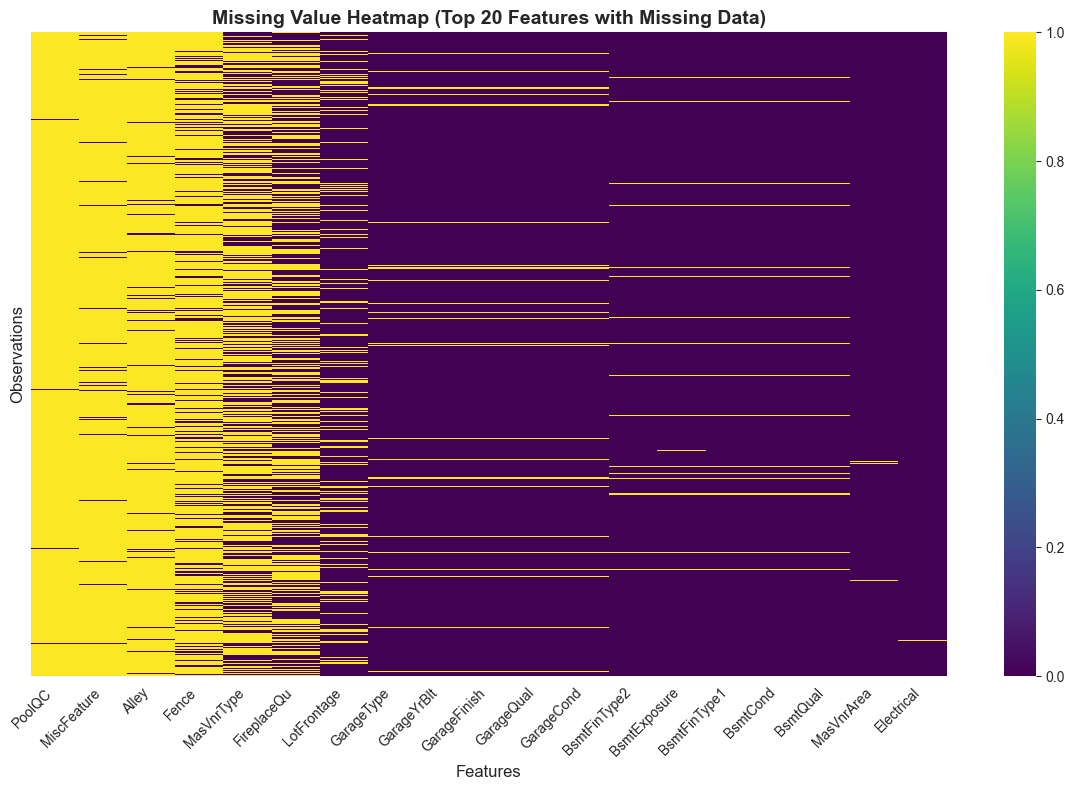


Total features with missing values: 19


In [230]:
# Calculate missing values
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

# Create a subset of features with missing values for visualization
missing_df = pd.DataFrame({
    'Feature': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing Percent': missing_percent.values
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

# Create heatmap of missing values
# Select top 20 features with most missing values for better visualization
top_missing = missing_df.head(20)

# Create a matrix for heatmap
missing_matrix = df[top_missing['Feature'].tolist()].isnull()

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(missing_matrix, yticklabels=False, cbar=True, cmap='viridis', ax=ax)
ax.set_title('Missing Value Heatmap (Top 20 Features with Missing Data)', fontsize=14, fontweight='bold')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Observations', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"\nTotal features with missing values: {len(missing_df)}")


Structural NA's (usually categorical so will just have to make a None category for them):
- PoolQC
- MiscFeature
- Alley
- Fence
- MasVnrType (already encoded as None)
- FireplaceQu
- GarageType        |
- GarageFinish      |
- GarageQual        | correlated
- GarageCond        |
- BsmtFinType2  |
- BsmtExposure  |
- BsmtFinType1  | correlated
- BsmtCond      |
- BsmtQual      |

True missing (require some kind of imputation):
- LotFrontage
- GarageYrBlt
- MasVnrArea


Other:
- Electrical (no NA by structure so need to impute it somehow (probably wont matter that much though cause only one house is NA for this))


## 5. Table of Features Sorted by % Missing


Features with Missing Values (Sorted by % Missing):
Feature                   Missing Count   Missing %       Data Type      
--------------------------------------------------------------------------------
PoolQC                    1453             99.52%      object         
MiscFeature               1406             96.30%      object         
Alley                     1369             93.77%      object         
Fence                     1179             80.75%      object         
MasVnrType                872              59.73%      object         
FireplaceQu               690              47.26%      object         
LotFrontage               259              17.74%      float64        
GarageType                81                5.55%      object         
GarageYrBlt               81                5.55%      float64        
GarageFinish              81                5.55%      object         
GarageQual                81                5.55%      object         
GarageCond  

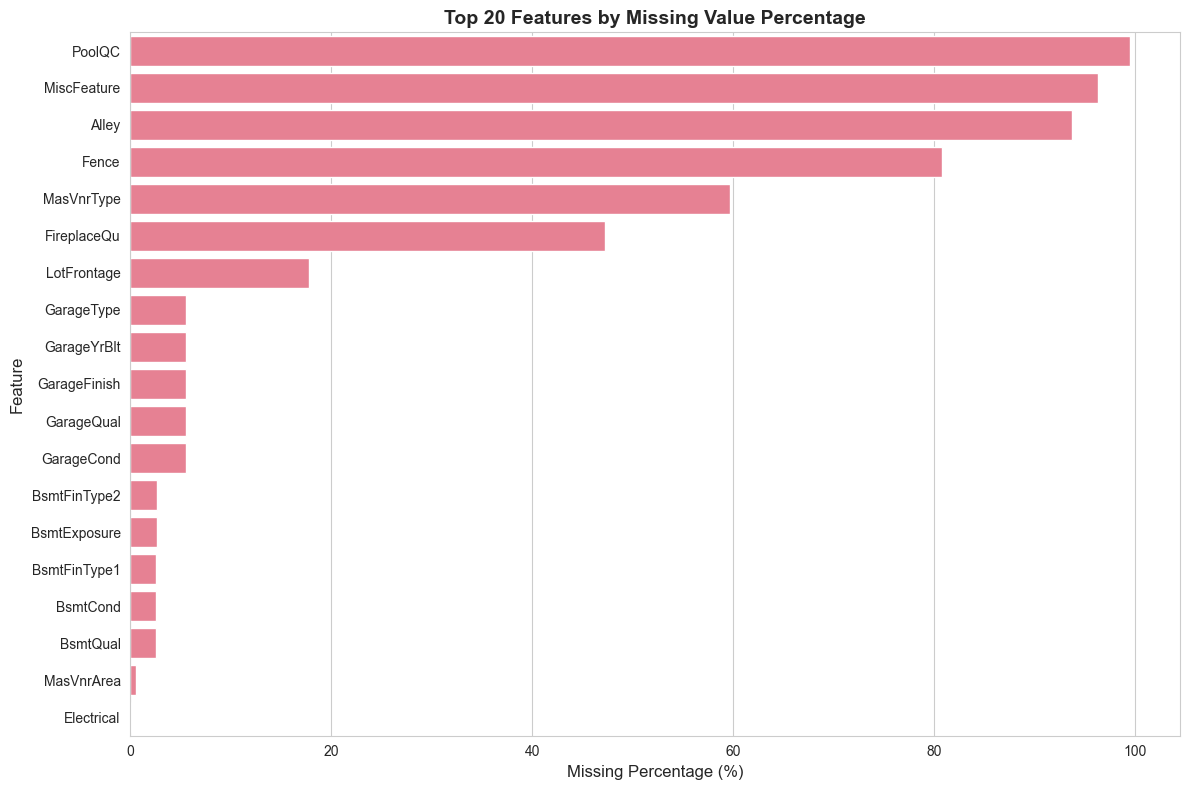

In [231]:
# Create comprehensive missing value table
missing_table = pd.DataFrame({
    'Feature': missing_data.index,
    'Missing Count': missing_data.values,
    'Missing Percent': missing_percent.values,
    'Data Type': df.dtypes.values
})
missing_table = missing_table[missing_table['Missing Count'] > 0].sort_values('Missing Percent', ascending=False)

# Display formatted table
print("Features with Missing Values (Sorted by % Missing):")
print("=" * 80)
print(f"{'Feature':<25} {'Missing Count':<15} {'Missing %':<15} {'Data Type':<15}")
print("-" * 80)
for idx, row in missing_table.iterrows():
    print(f"{row['Feature']:<25} {int(row['Missing Count']):<15} {row['Missing Percent']:>6.2f}%      {str(row['Data Type']):<15}")

# Visualize missing percentages
fig, ax = plt.subplots(figsize=(12, 8))
top_20_missing = missing_table.head(20)
sns.barplot(data=top_20_missing, y='Feature', x='Missing Percent', ax=ax)
ax.set_title('Top 20 Features by Missing Value Percentage', fontsize=14, fontweight='bold')
ax.set_xlabel('Missing Percentage (%)', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

plt.tight_layout()
plt.show()


How should we deal with...
PoolQC         Encode None                             
MiscFeature     Encode None  
Alley           Encode None     
Fence           Encode None
MasVnrType      Keep the same (already encoded as None)  
FireplaceQu     Encode None   
LotFrontage     Impute with median
GarageType      Encode None  
GarageYrBlt     Impute with 0
GarageFinish    Encode None
GarageQual      Encode None
GarageCond      Encode None  
BsmtFinType2    Encode None    
BsmtExposure    Encode None  
BsmtFinType1    Encode None     
BsmtCond        Encode None
BsmtQual        Encode None
MasVnrArea      Impute with 0
Electrical      Impute with mode

In [232]:
# Handle missing values according to the plan above

# Create a copy to avoid modifying the original dataframe
df_processed = df.copy()

print("Handling Missing Values:")
print("=" * 60)

# 1. Encode None for categorical variables with structural NAs
none_encode_vars = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtFinType2', 'BsmtExposure', 'BsmtFinType1', 'BsmtCond', 'BsmtQual',
    'MasVnrType', 'MasVnrArea'
]

for var in none_encode_vars:
    if var in df_processed.columns:
        missing_count = df_processed[var].isnull().sum()
        if missing_count > 0:
            # For object (categorical) columns, fill with 'None'
            if df_processed[var].dtype == 'object':
                df_processed[var] = df_processed[var].fillna('None')
                print(f"✓ {var:<20} Encoded {missing_count:>4} NAs as 'None' (categorical)")
            # For numeric columns (like MasVnrArea), fill with 0
            else:
                df_processed[var] = df_processed[var].fillna(0)
                print(f"✓ {var:<20} Encoded {missing_count:>4} NAs as 0 (numerical)")

# 2. Impute LotFrontage with median
if 'LotFrontage' in df_processed.columns:
    missing_count = df_processed['LotFrontage'].isnull().sum()
    if missing_count > 0:
        median_lotfrontage = df_processed['LotFrontage'].median()
        df_processed['LotFrontage'] = df_processed['LotFrontage'].fillna(median_lotfrontage)
        print(f"✓ LotFrontage         Imputed {missing_count:>4} NAs with median: {median_lotfrontage:.1f}")

# 3. Impute GarageYrBlt with 0
if 'GarageYrBlt' in df_processed.columns:
    missing_count = df_processed['GarageYrBlt'].isnull().sum()
    if missing_count > 0:
        df_processed['GarageYrBlt'] = df_processed['GarageYrBlt'].fillna(0)
        print(f"✓ GarageYrBlt         Imputed {missing_count:>4} NAs with 0")

# 4. Impute Electrical with mode
if 'Electrical' in df_processed.columns:
    missing_count = df_processed['Electrical'].isnull().sum()
    if missing_count > 0:
        mode_electrical = df_processed['Electrical'].mode()[0] if len(df_processed['Electrical'].mode()) > 0 else 'SBrkr'
        df_processed['Electrical'] = df_processed['Electrical'].fillna(mode_electrical)
        print(f"✓ Electrical         Imputed {missing_count:>4} NAs with mode: {mode_electrical}")

# Update the main dataframe
df = df_processed.copy()

print("\n" + "=" * 60)
print("Missing value handling complete!")
print(f"Remaining missing values: {df.isnull().sum().sum()}")
if df.isnull().sum().sum() > 0:
    print("\nFeatures with remaining missing values:")
    remaining_missing = df.isnull().sum()[df.isnull().sum() > 0]
    for var, count in remaining_missing.items():
        print(f"  {var}: {count}")


Handling Missing Values:
✓ PoolQC               Encoded 1453 NAs as 'None' (categorical)
✓ MiscFeature          Encoded 1406 NAs as 'None' (categorical)
✓ Alley                Encoded 1369 NAs as 'None' (categorical)
✓ Fence                Encoded 1179 NAs as 'None' (categorical)
✓ FireplaceQu          Encoded  690 NAs as 'None' (categorical)
✓ GarageType           Encoded   81 NAs as 'None' (categorical)
✓ GarageFinish         Encoded   81 NAs as 'None' (categorical)
✓ GarageQual           Encoded   81 NAs as 'None' (categorical)
✓ GarageCond           Encoded   81 NAs as 'None' (categorical)
✓ BsmtFinType2         Encoded   38 NAs as 'None' (categorical)
✓ BsmtExposure         Encoded   38 NAs as 'None' (categorical)
✓ BsmtFinType1         Encoded   37 NAs as 'None' (categorical)
✓ BsmtCond             Encoded   37 NAs as 'None' (categorical)
✓ BsmtQual             Encoded   37 NAs as 'None' (categorical)
✓ MasVnrType           Encoded  872 NAs as 'None' (categorical)
✓ MasVnrArea   

---

# SECTION 2.5 — FEATURE SELECTION

This section uses correlation analysis to identify the top predictive features before detailed univariate analysis. We'll focus on the strongest relationships with the log-transformed target variable.


In [233]:
# Feature Selection: Correlation Analysis
print("=" * 80)
print("FEATURE SELECTION USING CORRELATION ANALYSIS")
print("Target Variable: LogSalePrice (log-transformed)")
print("=" * 80)


FEATURE SELECTION USING CORRELATION ANALYSIS
Target Variable: LogSalePrice (log-transformed)


## Top Numeric Features by Correlation


In [234]:
# Prepare numeric features (exclude target and non-numeric)
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
# Exclude ID, target variables, and MSSubClass (categorical encoded as integer)
numeric_features = [f for f in numeric_features if f not in ['Id', 'SalePrice', 'LogSalePrice', 'MSSubClass']]

# Calculate correlation with LogSalePrice
corr_matrix_full = df[numeric_features + ['LogSalePrice']].corr()
correlations = corr_matrix_full['LogSalePrice'].sort_values(ascending=False)
top_numeric = correlations.head(11).drop('LogSalePrice')  # Top 10 excluding LogSalePrice itself

print(f"Total numeric features: {len(numeric_features)}")
print(f"\nTop 10 Numeric Features by Correlation with LogSalePrice:")
print("-" * 80)
for i, (feat, corr) in enumerate(top_numeric.items(), 1):
    print(f"{i:2d}. {feat:<25} Correlation: {corr:>6.3f}")

# Store recommended numeric features
recommended_numeric = list(top_numeric.index)


Total numeric features: 35

Top 10 Numeric Features by Correlation with LogSalePrice:
--------------------------------------------------------------------------------
 1. OverallQual               Correlation:  0.817
 2. GrLivArea                 Correlation:  0.701
 3. GarageCars                Correlation:  0.681
 4. GarageArea                Correlation:  0.651
 5. TotalBsmtSF               Correlation:  0.612
 6. 1stFlrSF                  Correlation:  0.597
 7. FullBath                  Correlation:  0.595
 8. YearBuilt                 Correlation:  0.587
 9. YearRemodAdd              Correlation:  0.566
10. TotRmsAbvGrd              Correlation:  0.534


## Top Categorical Features by Association


In [235]:
# Prepare categorical features
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

# Calculate association using Cramér's V
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Calculate Cramér's V statistic for categorical-categorical association"""
    try:
        confusion_matrix = pd.crosstab(x, y)
        if confusion_matrix.shape[0] < 2 or confusion_matrix.shape[1] < 2:
            return 0
        chi2 = chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum().sum()
        min_dim = min(confusion_matrix.shape) - 1
        return np.sqrt(chi2 / (n * min_dim)) if min_dim > 0 and n > 0 else 0
    except:
        return 0

# Bin target for categorical association tests (5 bins using quantiles)
y_log = df['LogSalePrice'].values
y_binned = pd.qcut(y_log, q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')

# Calculate Cramér's V for each categorical feature
print(f"\nTotal categorical features: {len(categorical_features)}")
print("Calculating Cramér's V (association strength)...")
cramers_results = []
for cat_feat in categorical_features:
    try:
        cat_data = df[cat_feat]
        # Only calculate if feature has variation
        if cat_data.nunique() > 1:
            v = cramers_v(cat_data, y_binned)
            cramers_results.append({'Feature': cat_feat, 'Cramers_V': v})
    except Exception as e:
        continue

cramers_df = pd.DataFrame(cramers_results).sort_values('Cramers_V', ascending=False)
top_categorical = cramers_df.head(10)

print(f"\nTop 10 Categorical Features by Cramér's V (Association Strength):")
print("-" * 80)
for i, (_, row) in enumerate(top_categorical.iterrows(), 1):
    print(f"{i:2d}. {row['Feature']:<25} Cramér's V: {row['Cramers_V']:>6.3f}")

# Store recommended categorical features
recommended_categorical = list(top_categorical['Feature'].values)



Total categorical features: 43
Calculating Cramér's V (association strength)...

Top 10 Categorical Features by Cramér's V (Association Strength):
--------------------------------------------------------------------------------
 1. Neighborhood              Cramér's V:  0.476
 2. KitchenQual               Cramér's V:  0.424
 3. ExterQual                 Cramér's V:  0.423
 4. GarageFinish              Cramér's V:  0.397
 5. BsmtQual                  Cramér's V:  0.381
 6. CentralAir                Cramér's V:  0.349
 7. GarageType                Cramér's V:  0.322
 8. FireplaceQu               Cramér's V:  0.304
 9. Foundation                Cramér's V:  0.304
10. BsmtFinType1              Cramér's V:  0.272


## Feature Selection Summary


In [236]:
# Summary of selected features
print("\n" + "=" * 80)
print("FEATURE SELECTION SUMMARY")
print("=" * 80)

print(f"\nRecommended Numeric Features ({len(recommended_numeric)}):")
print("-" * 80)
for i, feat in enumerate(recommended_numeric, 1):
    corr = correlations[feat]
    print(f"{i:2d}. {feat:<25} Correlation: {corr:>6.3f}")

print(f"\nRecommended Categorical Features ({len(recommended_categorical)}):")
print("-" * 80)
for i, feat in enumerate(recommended_categorical, 1):
    v = cramers_df[cramers_df['Feature'] == feat]['Cramers_V'].values[0]
    print(f"{i:2d}. {feat:<25} Cramér's V: {v:>6.3f}")

print(f"\n" + "=" * 80)
print(f"Total recommended features: {len(recommended_numeric) + len(recommended_categorical)}")
print(f"  - Numeric: {len(recommended_numeric)}")
print(f"  - Categorical: {len(recommended_categorical)}")
print("=" * 80)

# Store recommended features for use in later analysis
recommended_features = {
    'numeric': recommended_numeric,
    'categorical': recommended_categorical,
    'all': recommended_numeric + recommended_categorical
}

print(f"\n✓ Feature selection complete! Recommended features stored in 'recommended_features' dictionary.")



FEATURE SELECTION SUMMARY

Recommended Numeric Features (10):
--------------------------------------------------------------------------------
 1. OverallQual               Correlation:  0.817
 2. GrLivArea                 Correlation:  0.701
 3. GarageCars                Correlation:  0.681
 4. GarageArea                Correlation:  0.651
 5. TotalBsmtSF               Correlation:  0.612
 6. 1stFlrSF                  Correlation:  0.597
 7. FullBath                  Correlation:  0.595
 8. YearBuilt                 Correlation:  0.587
 9. YearRemodAdd              Correlation:  0.566
10. TotRmsAbvGrd              Correlation:  0.534

Recommended Categorical Features (10):
--------------------------------------------------------------------------------
 1. Neighborhood              Cramér's V:  0.476
 2. KitchenQual               Cramér's V:  0.424
 3. ExterQual                 Cramér's V:  0.423
 4. GarageFinish              Cramér's V:  0.397
 5. BsmtQual                  Cramér's 

---

# SECTION 3 — NUMERICAL FEATURES (UNIVARIATE)

**Note:** This section analyzes the top numeric features selected in Section 2.5 based on correlation with LogSalePrice.

## 6. Distribution Plots for Numerical Features


Using 10 recommended numeric features from Section 2.5


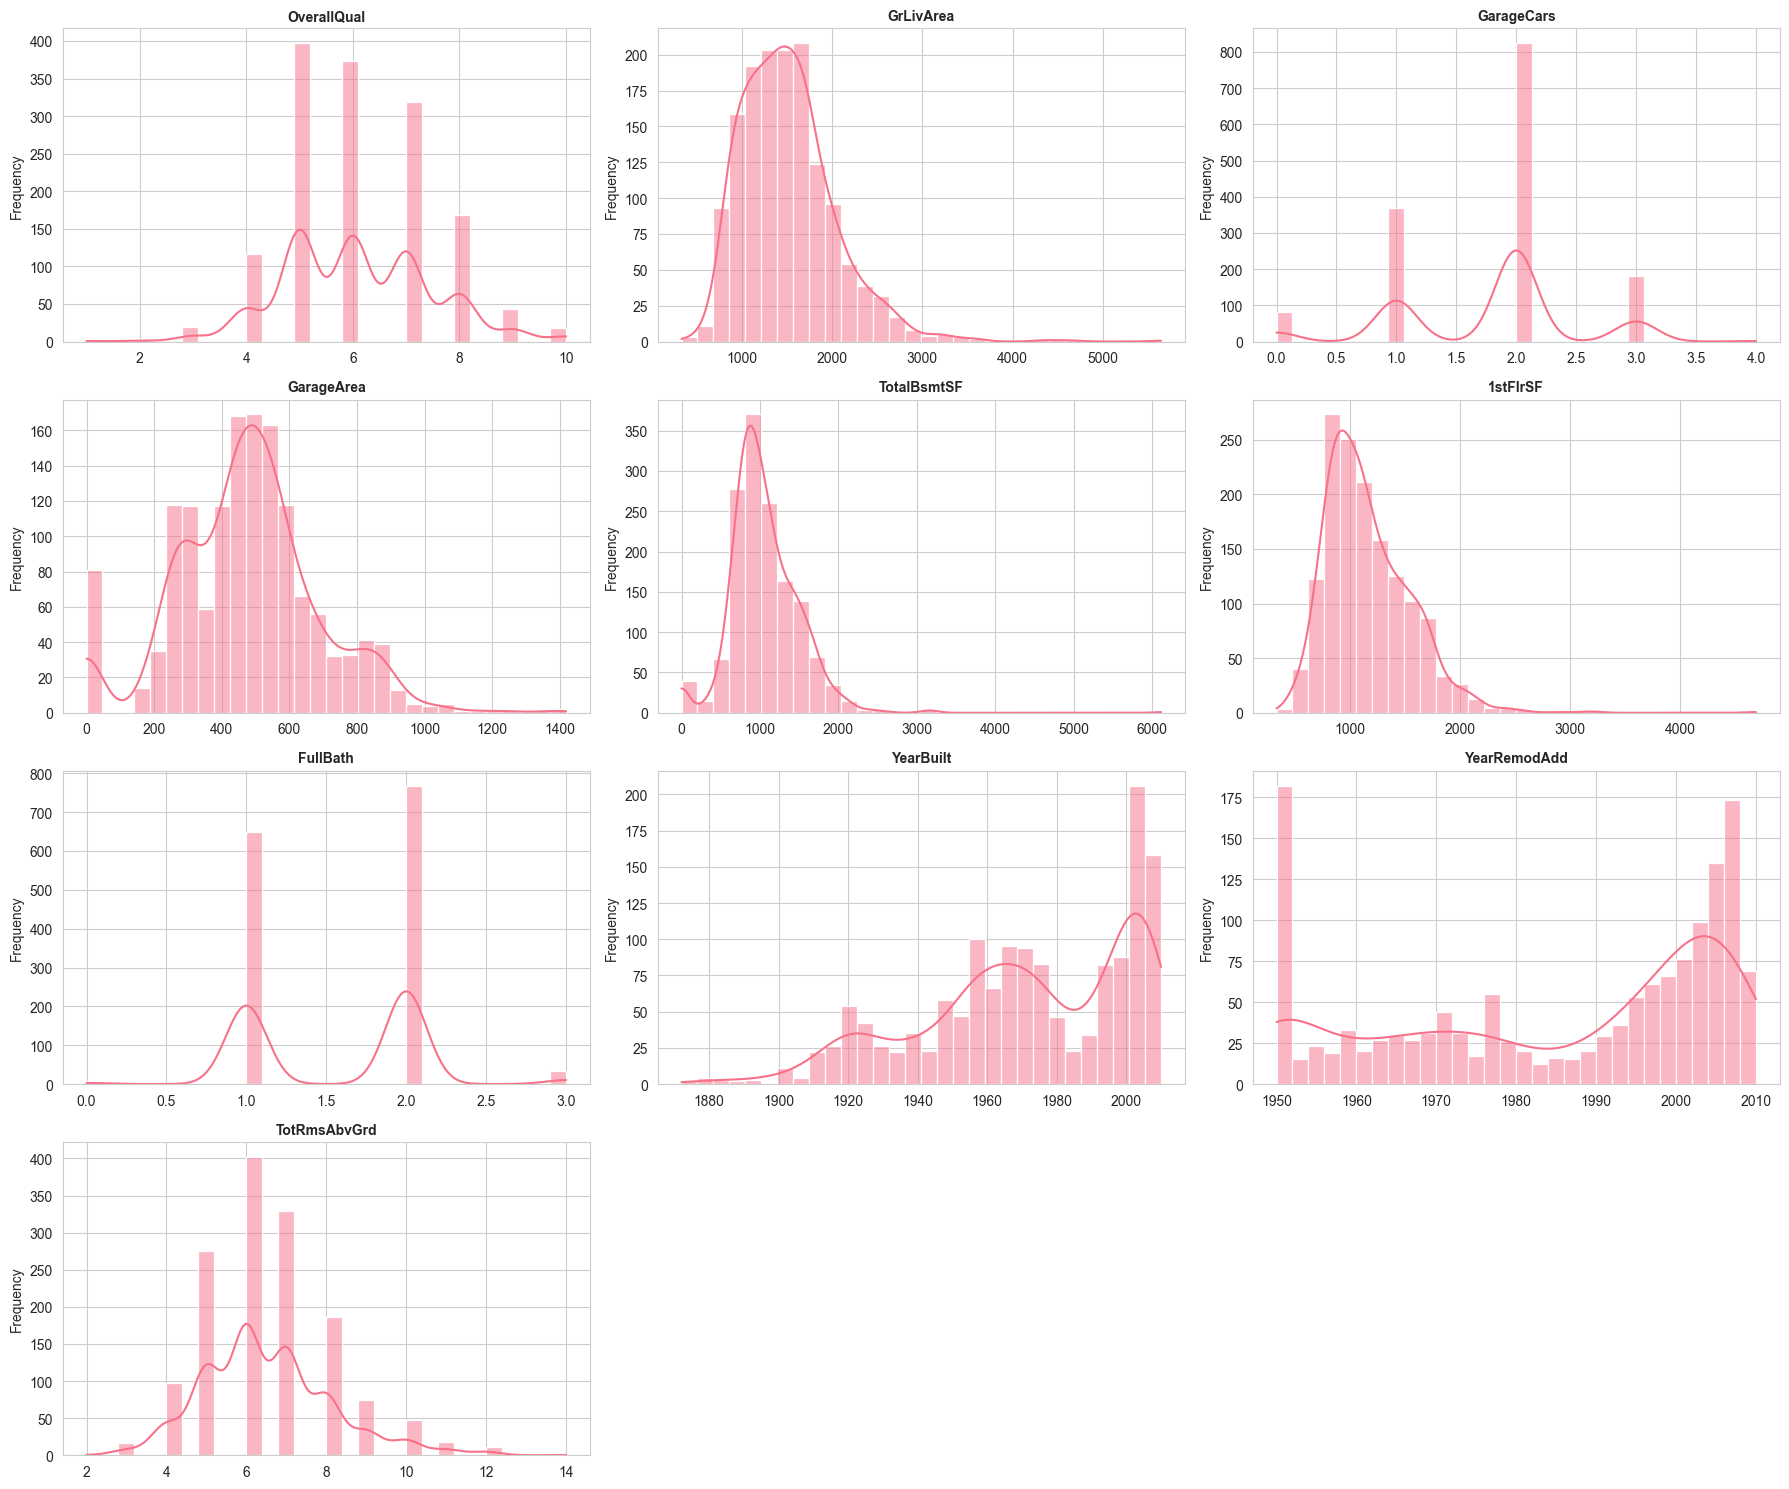


Skewness Analysis Numerical Features:
OverallQual          Skewness:    0.22
GrLivArea            Skewness:    1.37
GarageCars           Skewness:   -0.34
GarageArea           Skewness:    0.18
TotalBsmtSF          Skewness:    1.52
1stFlrSF             Skewness:    1.38
FullBath             Skewness:    0.04
YearBuilt            Skewness:   -0.61
YearRemodAdd         Skewness:   -0.50
TotRmsAbvGrd         Skewness:    0.68


In [237]:
# Helper function to plot distributions
def plot_numeric_distributions(df, numeric_cols, n_cols=3, figsize=(15, 12)):
    """Plot histograms with KDE for numerical features"""
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        if idx < len(axes):
            sns.histplot(df[col].dropna(), kde=True, bins=30, ax=axes[idx])
            axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
            axes[idx].set_xlabel('')
            axes[idx].set_ylabel('Frequency')
    
    # Hide extra subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Use recommended numeric features from Section 2.5
# Check if recommended_features exists, otherwise use all numeric features as fallback
if 'recommended_features' in globals() and 'numeric' in recommended_features:
    numeric_cols = recommended_features['numeric']
    print(f"Using {len(numeric_cols)} recommended numeric features from Section 2.5")
else:
    # Fallback: use all numeric features if recommended_features not available
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['Id', 'SalePrice', 'LogSalePrice']]
    print(f"Warning: Using all numeric features (recommended_features not found). Run Section 2.5 first.")

plot_numeric_distributions(df, numeric_cols, n_cols=3, figsize=(18, 15))

# Calculate skewness for key features
print("\nSkewness Analysis Numerical Features:")
print("=" * 60)
for col in numeric_cols:
    if col in df.columns:
        skew_val = df[col].skew()
        print(f"{col:<20} Skewness: {skew_val:>7.2f}")


### 📊 How to Analyze These Plots:

**Detecting Skewed Variables:**
- **Right skew**: Distribution has a long tail to the right (most values on left, few high values)
- **Left skew**: Distribution has a long tail to the left
- **Symmetric**: Bell-shaped, normal distribution

**Heavy Right Tails Requiring Log Transform:**
- **Skewness > 1**: Strong right skew, consider log transformation
- **Skewness > 2**: Very strong skew, log transform highly recommended
- **Common candidates**: LotArea, GrLivArea, TotalBsmtSF, GarageArea (area/size features)

**Suspicious Multimodal Patterns:**
- **Multiple peaks**: May indicate different property types or subpopulations
- **Bimodal distribution**: Could suggest two distinct groups (e.g., old vs new houses)
- **Action**: Consider creating categorical features or separate models for different modes

**Transformation Strategy:**
- **Log transform**: For right-skewed area/size features (LotArea, GrLivArea, etc.)
- **Square root**: Alternative for less severe skewness
- **Box-Cox**: Advanced transformation for optimal normalization


## 7. Boxplots for Numerical Features


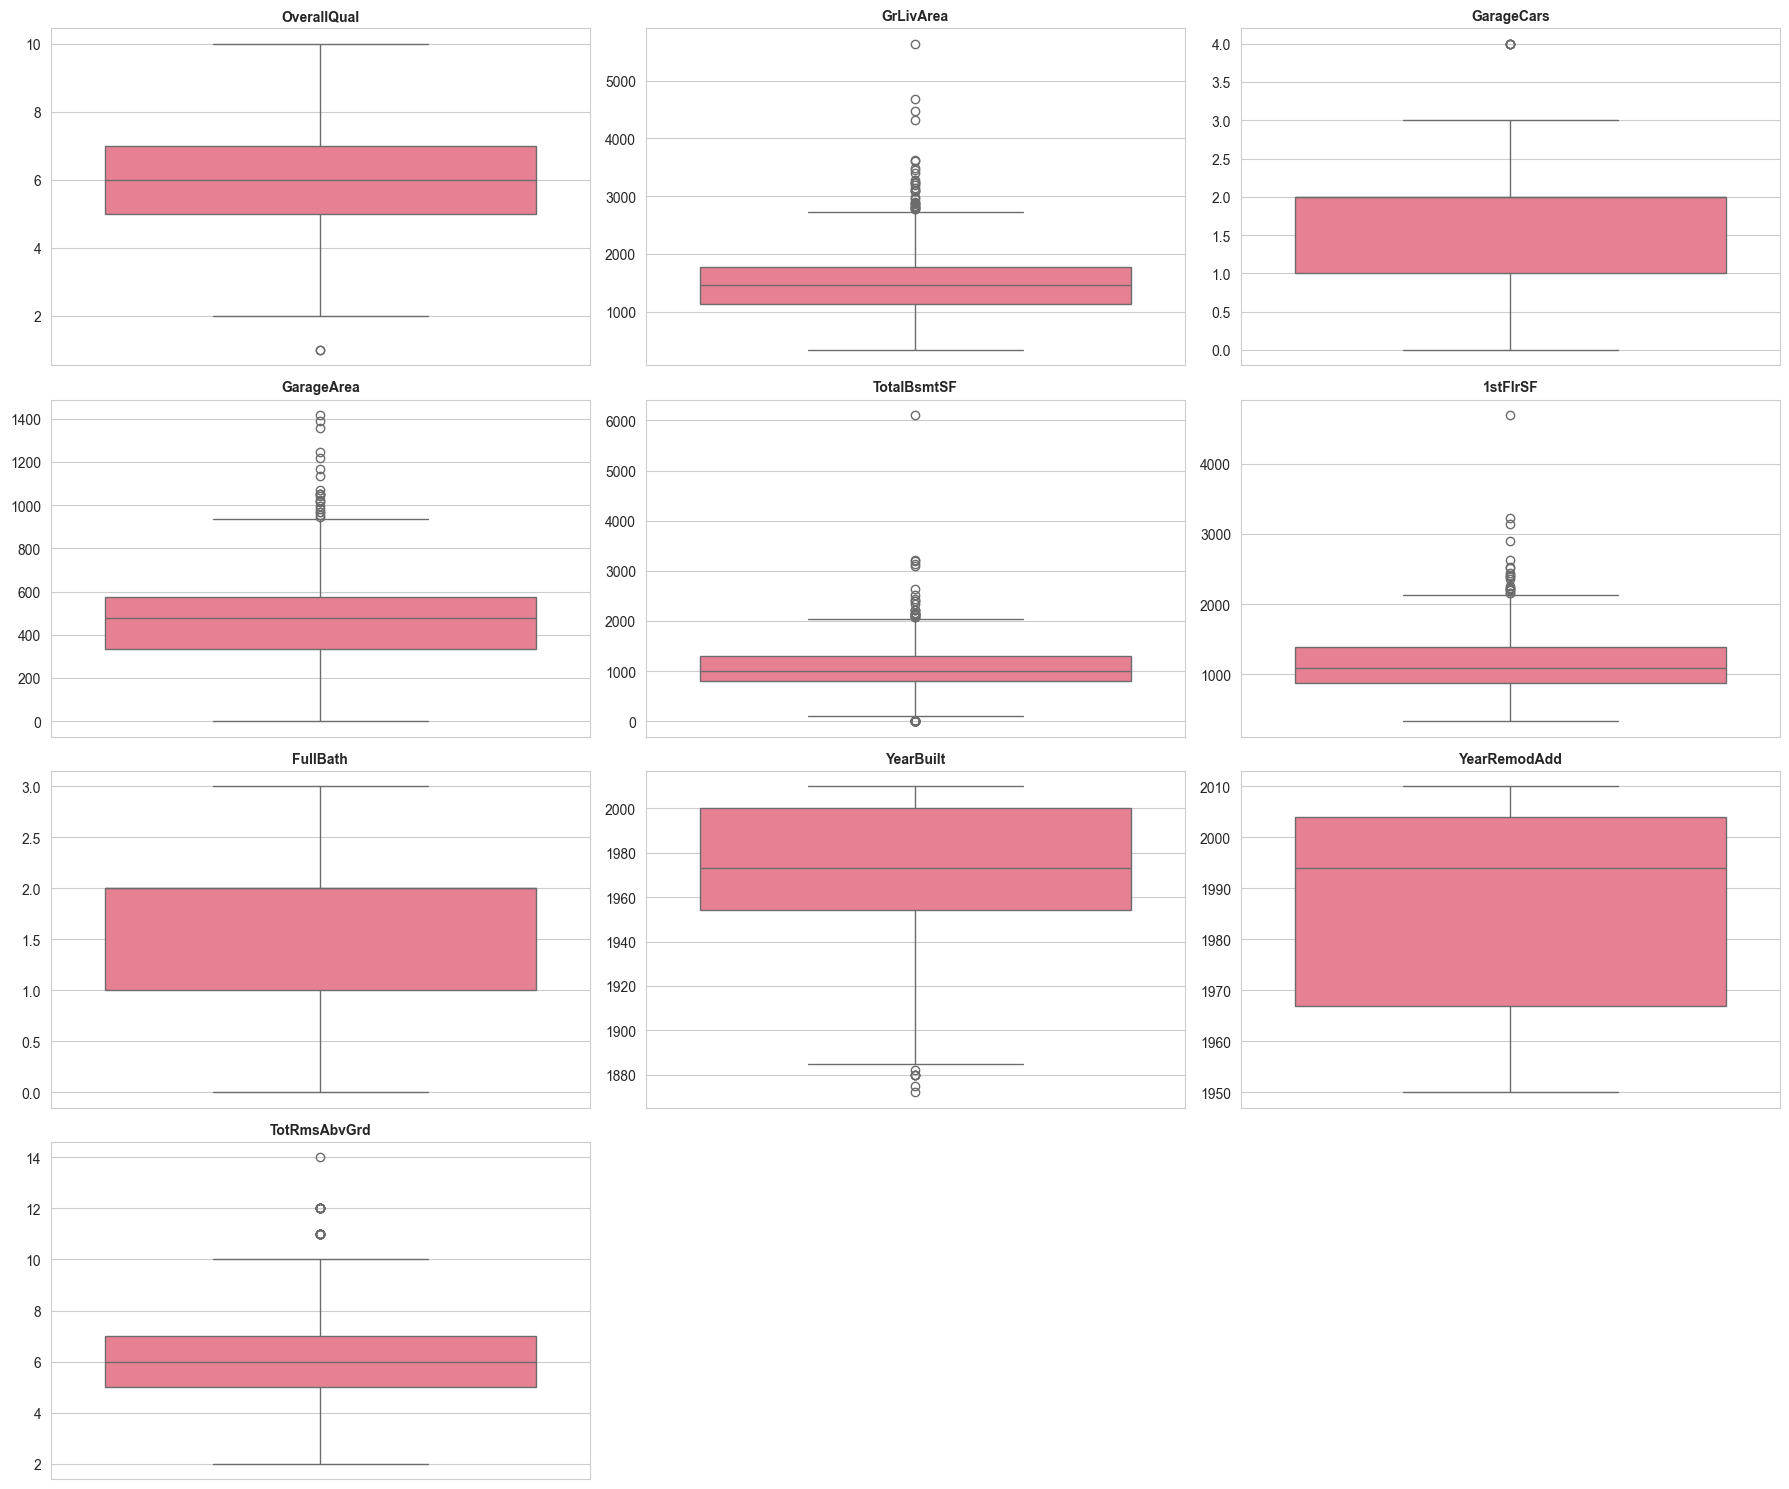


Potential Outliers (values beyond 1.5×IQR):
OverallQual          Outliers:    2 ( 0.14%)
GrLivArea            Outliers:   31 ( 2.12%)
GarageCars           Outliers:    5 ( 0.34%)
GarageArea           Outliers:   21 ( 1.44%)
TotalBsmtSF          Outliers:   61 ( 4.18%)
1stFlrSF             Outliers:   20 ( 1.37%)
YearBuilt            Outliers:    7 ( 0.48%)
TotRmsAbvGrd         Outliers:   30 ( 2.05%)


In [238]:
# Helper function to plot boxplots
def plot_numeric_boxplots(df, numeric_cols, n_cols=3, figsize=(15, 12)):
    """Plot boxplots for numerical features"""
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(numeric_cols):
        if idx < len(axes):
            sns.boxplot(y=df[col].dropna(), ax=axes[idx])
            axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
            axes[idx].set_ylabel('')
    
    # Hide extra subplots
    for idx in range(len(numeric_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot boxplots for key numerical features
plot_numeric_boxplots(df, numeric_cols, n_cols=3, figsize=(18, 15))

# Identify potential outliers
print("\nPotential Outliers (values beyond 1.5×IQR):")
print("=" * 60)
for col in numeric_cols:
    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        if len(outliers) > 0:
            print(f"{col:<20} Outliers: {len(outliers):>4} ({len(outliers)/len(df)*100:>5.2f}%)")


### 📊 How to Analyze These Plots:

**Detecting Potential Measurement Errors:**
- **Extreme outliers**: Points far beyond the whiskers may indicate data entry errors
- **Impossible values**: Negative areas, unrealistic sizes (e.g., 10,000 sq ft house)
- **Action**: Verify with domain knowledge, consider capping or removal

**Unusually Large Values:**
- **High-value outliers**: May represent luxury properties or measurement errors
- **Impact on models**: Can distort linear models, less impact on tree-based models
- **Strategies**:
  - **Capping**: Set upper limit at 99th percentile
  - **Log transformation**: Reduces impact of extreme values
  - **Robust scaling**: Use median and IQR instead of mean and std

**When to Investigate Further:**
- **>5% outliers**: High proportion suggests potential data quality issues
- **Clustered outliers**: Multiple outliers in same observations may indicate systematic errors
- **Domain validation**: Cross-check with real estate data or expert knowledge


---

# SECTION 4 — CATEGORICAL FEATURES (UNIVARIATE)

**Note:** This section analyzes the top categorical features selected in Section 2.5 based on Cramér's V association strength.

## 8. Bar Charts for Categorical Features


Using 10 recommended categorical features from Section 2.5


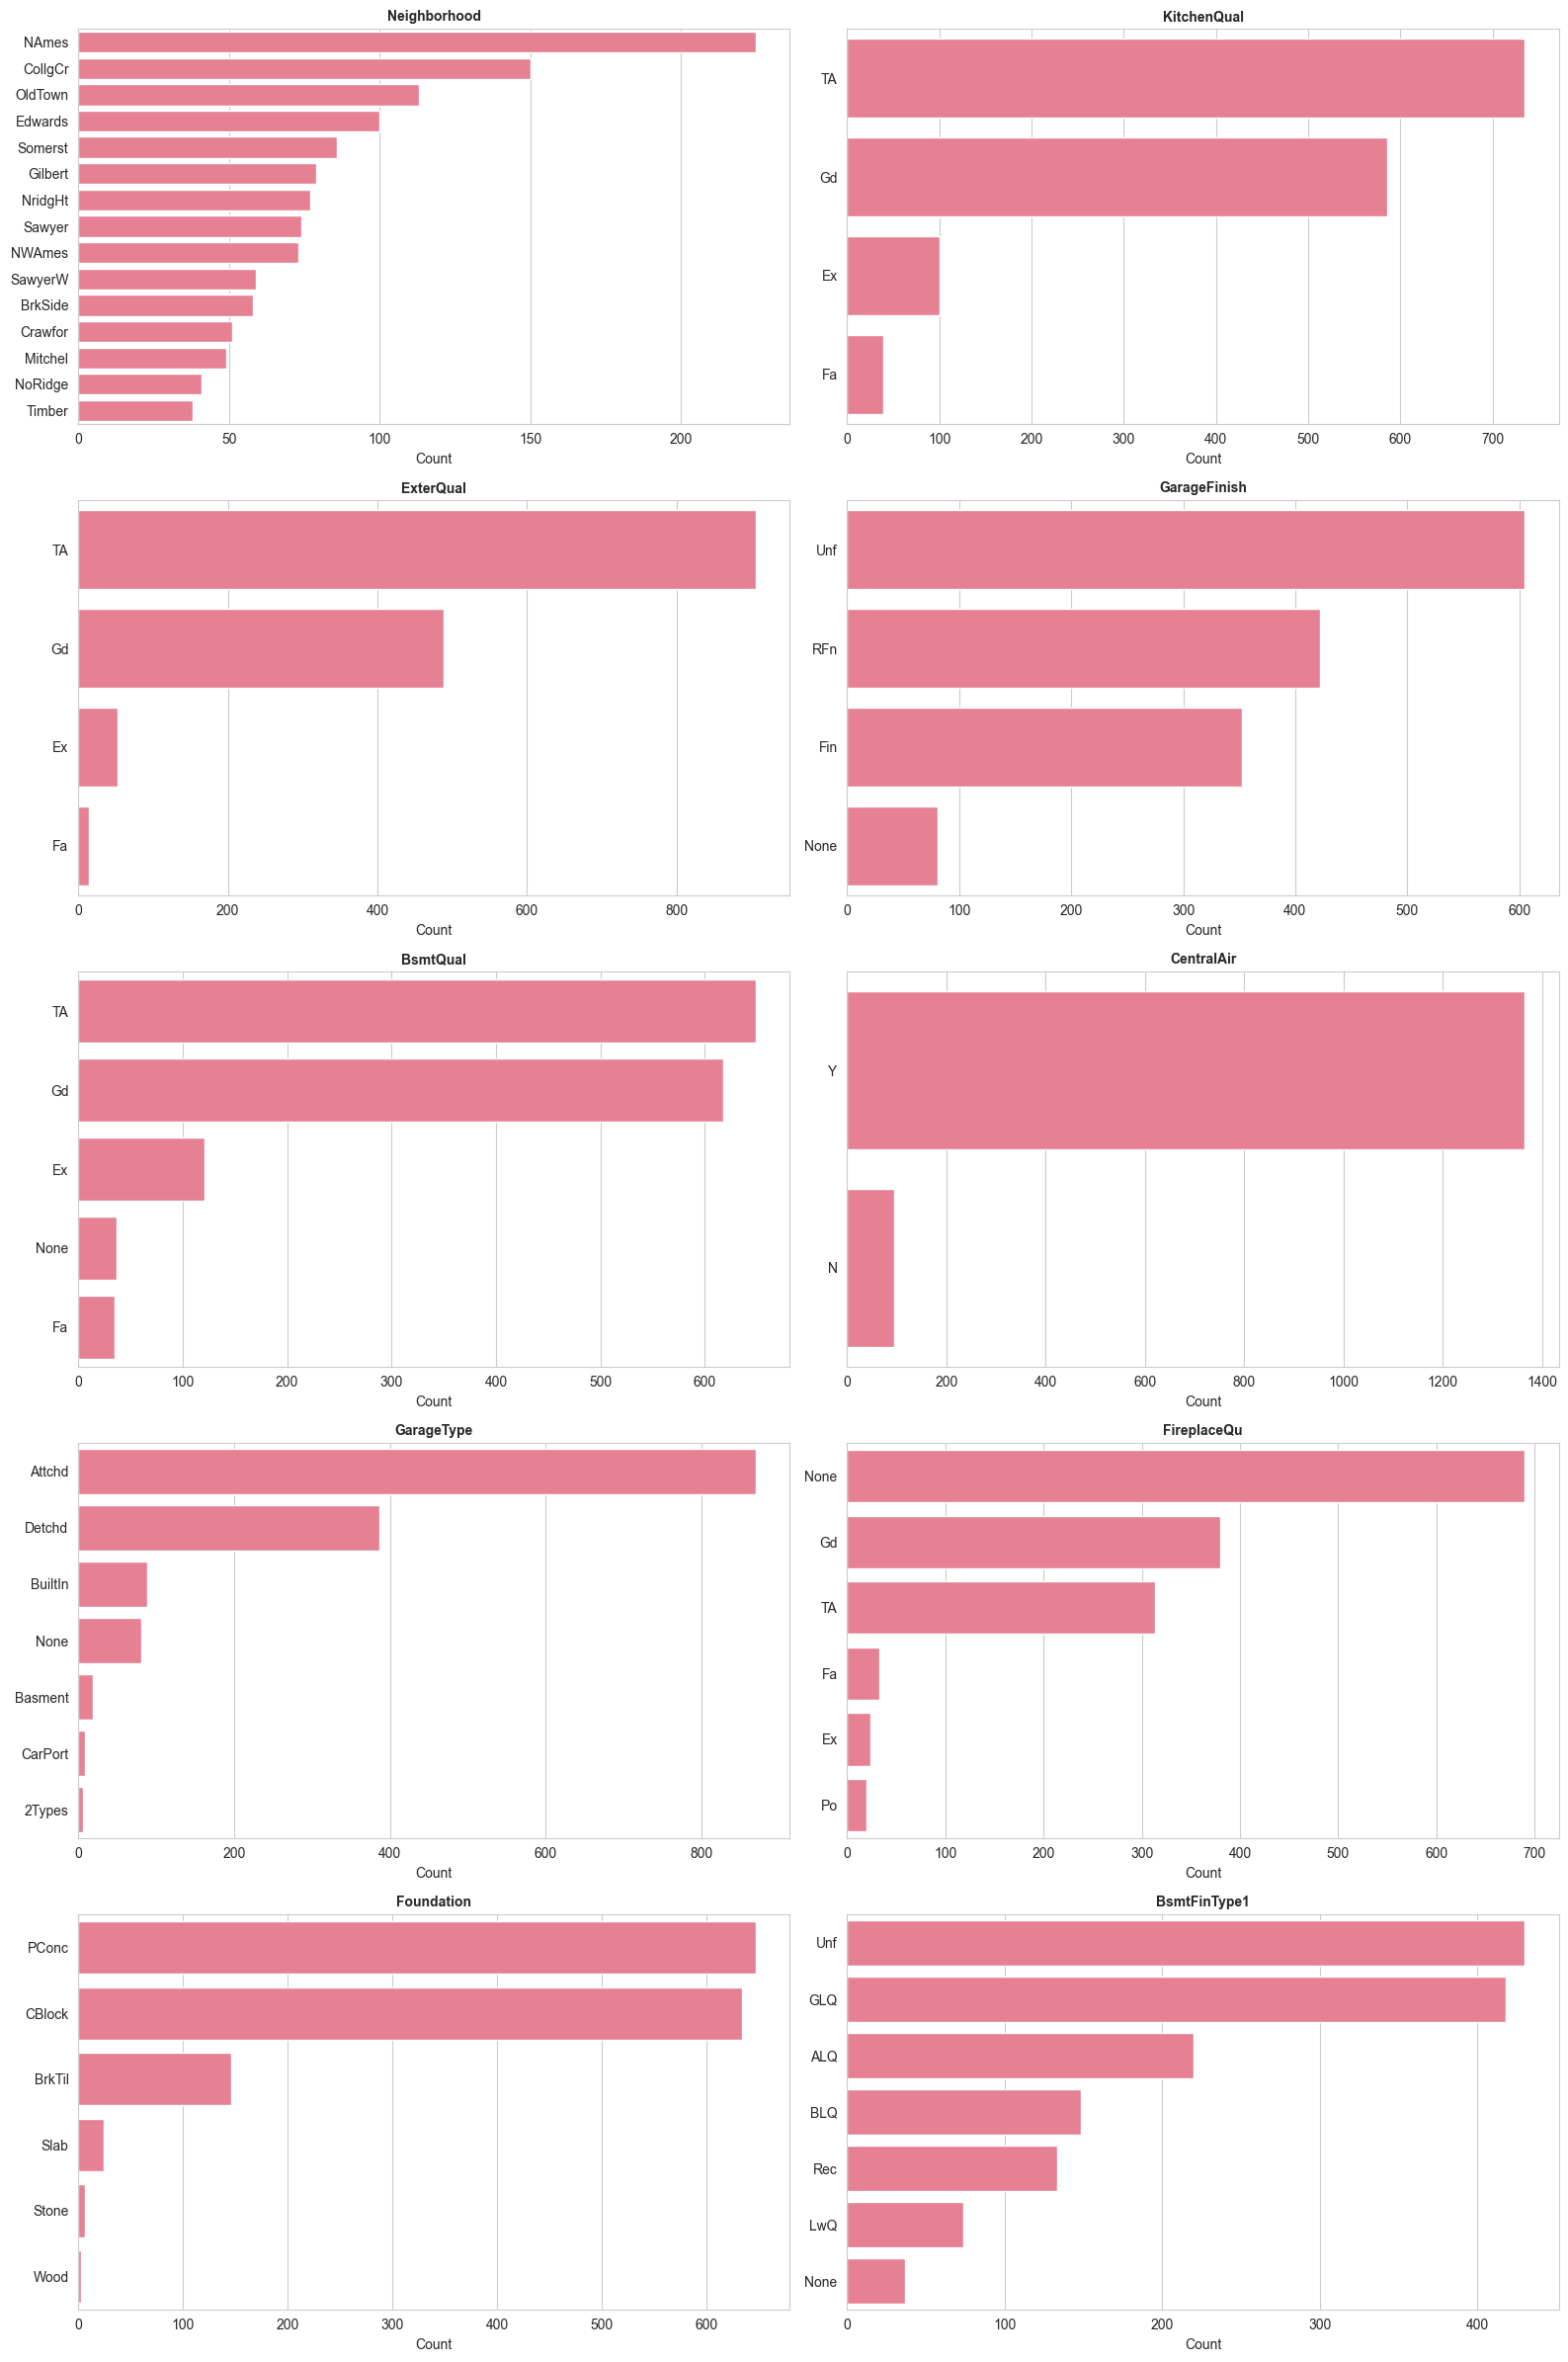


Category Distribution Analysis:
Neighborhood         Categories: 25, Dominant:  15.4%, Rare (<10):  2
KitchenQual          Categories:  4, Dominant:  50.3%, Rare (<10):  0
ExterQual            Categories:  4, Dominant:  62.1%, Rare (<10):  0
GarageFinish         Categories:  4, Dominant:  41.4%, Rare (<10):  0
BsmtQual             Categories:  5, Dominant:  44.5%, Rare (<10):  0
CentralAir           Categories:  2, Dominant:  93.5%, Rare (<10):  0
GarageType           Categories:  7, Dominant:  59.6%, Rare (<10):  2
FireplaceQu          Categories:  6, Dominant:  47.3%, Rare (<10):  0
Foundation           Categories:  6, Dominant:  44.3%, Rare (<10):  2
BsmtFinType1         Categories:  7, Dominant:  29.5%, Rare (<10):  0


In [239]:
# Helper function to plot categorical distributions
def plot_categorical_distributions(df, cat_cols, n_cols=2, figsize=(15, 20)):
    """Plot bar charts for categorical features"""
    n_rows = (len(cat_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, col in enumerate(cat_cols):
        if idx < len(axes) and col in df.columns:
            value_counts = df[col].value_counts().head(15)  # Top 15 categories
            sns.barplot(x=value_counts.values, y=value_counts.index, ax=axes[idx])
            axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
            axes[idx].set_xlabel('Count')
            axes[idx].set_ylabel('')
    
    # Hide extra subplots
    for idx in range(len(cat_cols), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Use recommended categorical features from Section 2.5
# Check if recommended_features exists, otherwise use all categorical features as fallback
if 'recommended_features' in globals() and 'categorical' in recommended_features:
    categorical_cols = recommended_features['categorical']
    print(f"Using {len(categorical_cols)} recommended categorical features from Section 2.5")
else:
    # Fallback: use all categorical features if recommended_features not available
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    print(f"Warning: Using all categorical features (recommended_features not found). Run Section 2.5 first.")

plot_categorical_distributions(df, categorical_cols, n_cols=2, figsize=(16, 24))

# Analyze category distribution
print("\nCategory Distribution Analysis:")
print("=" * 60)
for col in categorical_cols:
    if col in df.columns:
        value_counts = df[col].value_counts()
        n_categories = len(value_counts)
        dominant_pct = (value_counts.iloc[0] / len(df)) * 100
        rare_categories = (value_counts < 10).sum()
        print(f"{col:<20} Categories: {n_categories:>2}, Dominant: {dominant_pct:>5.1f}%, Rare (<10): {rare_categories:>2}")


### 📊 How to Analyze These Plots:

**Identifying Dominant vs Rare Categories:**
- **Dominant category**: One category with >50% of observations (e.g., CentralAir='Y')
  - Low predictive power if too dominant
  - Consider binary encoding or removal
- **Rare categories**: Categories with <10 observations
  - Can cause overfitting
  - Merge into "Other" category

**Category Merging Strategy:**
- **Low frequency categories**: Combine categories with <5% frequency into "Other"
- **Similar categories**: Merge semantically similar categories (e.g., different roof materials)
- **Ordinal encoding**: If categories have natural order (e.g., quality ratings), use ordinal encoding

**Low Variation (Poor Predictors):**
- **High dominance (>90%)**: Feature has little variation, minimal predictive power
- **Low cardinality with imbalance**: Few categories, one dominates → consider removal
- **Action**: Calculate feature importance or correlation to confirm before removal


---

# SECTION 5 — PRELIMINARY FEATURE ENGINEERING

This section performs preliminary feature engineering to create new features and transform existing ones for better model performance. We'll create composite features, apply transformations, and convert variables to more appropriate types.


In [240]:
# Preliminary Feature Engineering
print("=" * 80)
print("PRELIMINARY FEATURE ENGINEERING")
print("=" * 80)

# Track what we create/transform
new_features = []
converted_features = []
log_transformed = []
binary_features = []


PRELIMINARY FEATURE ENGINEERING


## Numeric Feature Engineering


### 1. Convert Discrete Counts to Categorical


In [241]:
# Convert GarageCars and FullBath to categorical (discrete counts work better as categories)
print("\nConverting discrete numeric features to categorical:")
print("-" * 80)

if 'GarageCars' in df.columns:
    df['GarageCars'] = df['GarageCars'].astype(str)
    converted_features.append('GarageCars (numeric → categorical)')
    print("✓ GarageCars converted to categorical")

if 'FullBath' in df.columns:
    df['FullBath'] = df['FullBath'].astype(str)
    converted_features.append('FullBath (numeric → categorical)')
    print("✓ FullBath converted to categorical")



Converting discrete numeric features to categorical:
--------------------------------------------------------------------------------
✓ GarageCars converted to categorical
✓ FullBath converted to categorical


### 2. Create TotalSF Feature


In [242]:
# Create TotalSF: Sum of most important square footage features
# Combines above-grade (GrLivArea) and below-grade (TotalBsmtSF) living area
# Note: GrLivArea already includes 1stFlrSF + 2ndFlrSF, so we don't double-count
print("\nCreating TotalSF feature:")
print("-" * 80)

# Start with GrLivArea (above grade living area = 1stFlrSF + 2ndFlrSF)
sf_features = []
if 'GrLivArea' in df.columns:
    df['TotalSF'] = df['GrLivArea'].fillna(0)
    sf_features.append('GrLivArea')
else:
    df['TotalSF'] = 0

# Add TotalBsmtSF (total basement square footage)
if 'TotalBsmtSF' in df.columns:
    df['TotalSF'] = df['TotalSF'] + df['TotalBsmtSF'].fillna(0)
    sf_features.append('TotalBsmtSF')

new_features.append(f"TotalSF (sum of: {', '.join(sf_features)})")
print(f"✓ Created TotalSF = {' + '.join(sf_features)}")
print(f"  TotalSF represents: Above-grade + Below-grade living area")
print(f"  TotalSF range: {df['TotalSF'].min():.0f} to {df['TotalSF'].max():.0f} sq ft")

# Update recommended_features: Remove components of engineered features, add new engineered features
if 'recommended_features' in globals() and 'numeric' in recommended_features:
    # Remove components that are now part of engineered features
    # 1. Remove GrLivArea, TotalBsmtSF, 1stFlrSF (all part of TotalSF)
    # 2. Remove YearBuilt, YearRemodAdd (replaced by Age and AgeSinceRemodel)
    features_to_remove = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd']
    recommended_features['numeric'] = [f for f in recommended_features['numeric'] 
                                       if f not in features_to_remove]
    
    # Add engineered features if not already present
    new_features_to_add = []
    if 'TotalSF' not in recommended_features['numeric']:
        recommended_features['numeric'].append('TotalSF')
        new_features_to_add.append('TotalSF')
    
    removed_str = ', '.join(features_to_remove)
    if new_features_to_add:
        added_str = ', '.join(new_features_to_add)
        print(f"\n✓ Updated recommended_features: Removed {removed_str}, added {added_str}")
    else:
        print(f"\n✓ Updated recommended_features: Removed {removed_str} (engineered features already present)")
    
    # Also update the 'all' list
    if 'all' in recommended_features:
        recommended_features['all'] = [f for f in recommended_features['all'] 
                                       if f not in features_to_remove]
        for feat in new_features_to_add:
            if feat not in recommended_features['all']:
                recommended_features['all'].append(feat)



Creating TotalSF feature:
--------------------------------------------------------------------------------
✓ Created TotalSF = GrLivArea + TotalBsmtSF
  TotalSF represents: Above-grade + Below-grade living area
  TotalSF range: 334 to 11752 sq ft

✓ Updated recommended_features: Removed GrLivArea, TotalBsmtSF, 1stFlrSF, YearBuilt, YearRemodAdd, added TotalSF


### 3. Create Age Features


In [243]:
# Create Age features: Age of house and years since remodel
print("\nCreating Age features:")
print("-" * 80)

current_year = 2025

# Age: Current year - YearBuilt
if 'YearBuilt' in df.columns:
    df['Age'] = current_year - df['YearBuilt']
    new_features.append('Age (2025 - YearBuilt)')
    print(f"✓ Created Age feature")
    print(f"  Age range: {df['Age'].min():.0f} to {df['Age'].max():.0f} years")

# AgeSinceRemodel: Current year - YearRemodAdd
if 'YearRemodAdd' in df.columns:
    df['AgeSinceRemodel'] = current_year - df['YearRemodAdd']
    # If YearRemodAdd equals YearBuilt (no remodel), set to 0 or same as Age
    # Actually, if no remodel, AgeSinceRemodel = Age makes sense
    no_remodel_mask = df['YearRemodAdd'] == df['YearBuilt']
    df.loc[no_remodel_mask, 'AgeSinceRemodel'] = df.loc[no_remodel_mask, 'Age']
    new_features.append('AgeSinceRemodel (2025 - YearRemodAdd)')
    print(f"✓ Created AgeSinceRemodel feature")
    print(f"  AgeSinceRemodel range: {df['AgeSinceRemodel'].min():.0f} to {df['AgeSinceRemodel'].max():.0f} years")
    print(f"  Houses with no remodel (AgeSinceRemodel = Age): {no_remodel_mask.sum()}")

# Update recommended_features: Add Age and AgeSinceRemodel to numeric features
# (YearBuilt and YearRemodAdd should already be removed in the TotalSF section above)
if 'recommended_features' in globals() and 'numeric' in recommended_features:
    # Ensure YearBuilt and YearRemodAdd are removed (in case they weren't removed earlier)
    if 'YearBuilt' in recommended_features['numeric']:
        recommended_features['numeric'].remove('YearBuilt')
    if 'YearRemodAdd' in recommended_features['numeric']:
        recommended_features['numeric'].remove('YearRemodAdd')
    
    # Add Age if not already present
    if 'Age' in df.columns and 'Age' not in recommended_features['numeric']:
        recommended_features['numeric'].append('Age')
        print(f"\n✓ Added Age to recommended_features (replaces YearBuilt)")
    
    # Add AgeSinceRemodel if not already present
    if 'AgeSinceRemodel' in df.columns and 'AgeSinceRemodel' not in recommended_features['numeric']:
        recommended_features['numeric'].append('AgeSinceRemodel')
        print(f"✓ Added AgeSinceRemodel to recommended_features (replaces YearRemodAdd)")
    
    # Also update the 'all' list
    if 'all' in recommended_features:
        if 'YearBuilt' in recommended_features['all']:
            recommended_features['all'].remove('YearBuilt')
        if 'YearRemodAdd' in recommended_features['all']:
            recommended_features['all'].remove('YearRemodAdd')
        if 'Age' in df.columns and 'Age' not in recommended_features['all']:
            recommended_features['all'].append('Age')
        if 'AgeSinceRemodel' in df.columns and 'AgeSinceRemodel' not in recommended_features['all']:
            recommended_features['all'].append('AgeSinceRemodel')



Creating Age features:
--------------------------------------------------------------------------------
✓ Created Age feature
  Age range: 15 to 153 years
✓ Created AgeSinceRemodel feature
  AgeSinceRemodel range: 15 to 75 years
  Houses with no remodel (AgeSinceRemodel = Age): 764

✓ Added Age to recommended_features (replaces YearBuilt)
✓ Added AgeSinceRemodel to recommended_features (replaces YearRemodAdd)


### 4. Log Transform Right-Skewed Features


In [244]:
# Log transform significantly right-skewed numeric features
print("\nApplying log transformation to right-skewed features:")
print("-" * 80)

# Get recommended numeric features if available, otherwise use important area/size features
if 'recommended_features' in globals() and 'numeric' in recommended_features:
    features_to_check = recommended_features['numeric'].copy()
    # Exclude components of engineered features
    features_to_exclude = ['GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'YearRemodAdd']
    features_to_check = [f for f in features_to_check if f not in features_to_exclude]
    print(f"Checking {len(features_to_check)} recommended numeric features for skewness...")
    print(f"  (Excluded {', '.join(features_to_exclude)} - using engineered features instead)")
else:
    # Fallback: check important area/size features (excluding components of engineered features)
    features_to_check = ['LotArea', '2ndFlrSF', 
                         'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'MasVnrArea']
    print(f"Using fallback list of {len(features_to_check)} important area/size features...")
    print("  (Excluded components of engineered features)")

# Check skewness and transform if > 1
for feat in features_to_check:
    if feat in df.columns:
        # Only transform numeric features (not already converted to categorical)
        if df[feat].dtype in ['int64', 'float64']:
            skew_val = df[feat].skew()
            if skew_val > 1:  # Significantly right-skewed
                new_col_name = f"{feat}_log"
                df[new_col_name] = np.log1p(df[feat].fillna(0))
                skew_after = df[new_col_name].skew()
                log_transformed.append({
                    'Feature': feat,
                    'Original_Skewness': skew_val,
                    'After_Log_Skewness': skew_after,
                    'New_Column': new_col_name
                })
                print(f"✓ {feat:<20} Skewness: {skew_val:>6.2f} → {skew_after:>6.2f} (created {new_col_name})")

if len(log_transformed) == 0:
    print("No features required log transformation (all skewness ≤ 1)")



Applying log transformation to right-skewed features:
--------------------------------------------------------------------------------
Checking 8 recommended numeric features for skewness...
  (Excluded GrLivArea, TotalBsmtSF, 1stFlrSF, YearBuilt, YearRemodAdd - using engineered features instead)
✓ TotalSF              Skewness:   1.78 →  -0.34 (created TotalSF_log)


## Categorical Feature Engineering


### Convert Quality Features to Binary


In [245]:
# Convert quality/condition features to binary "above-average" features
print("\nConverting quality features to binary (above-average):")
print("-" * 80)

# Define quality mappings for categorical features
quality_mappings = {
    'KitchenQual': {'above_avg': ['Gd', 'Ex'], 'below_avg': ['TA', 'Fa', 'Po', 'None']},
    'ExterQual': {'above_avg': ['Gd', 'Ex'], 'below_avg': ['TA', 'Fa', 'Po', 'None']},
    'BsmtQual': {'above_avg': ['Gd', 'Ex'], 'below_avg': ['TA', 'Fa', 'Po', 'None']},
    'GarageQual': {'above_avg': ['Gd', 'Ex'], 'below_avg': ['TA', 'Fa', 'Po', 'None']},
    'FireplaceQu': {'above_avg': ['Gd', 'Ex'], 'below_avg': ['TA', 'Fa', 'Po', 'None']},
    'HeatingQC': {'above_avg': ['Gd', 'Ex'], 'below_avg': ['TA', 'Fa', 'Po', 'None']},
}

# Get recommended categorical features if available
if 'recommended_features' in globals() and 'categorical' in recommended_features:
    cat_features_to_check = recommended_features['categorical']
else:
    cat_features_to_check = ['KitchenQual', 'ExterQual', 'BsmtQual', 'GarageQual', 
                             'FireplaceQu', 'HeatingQC', 'OverallQual']

# Process each quality feature
for feat in cat_features_to_check:
    if feat in df.columns:
        # Handle OverallQual separately (it's numeric)
        if feat == 'OverallQual' and df[feat].dtype in ['int64', 'float64']:
            new_col_name = f"{feat}_AboveAvg"
            df[new_col_name] = (df[feat] >= 6).astype(int)
            binary_features.append(f"{feat} → {new_col_name} (>= 6)")
            print(f"✓ {feat:<20} → {new_col_name} (1 if >= 6, 0 otherwise)")
        
        # Handle categorical quality features
        elif feat in quality_mappings:
            new_col_name = f"{feat}_AboveAvg"
            above_avg_values = quality_mappings[feat]['above_avg']
            df[new_col_name] = df[feat].isin(above_avg_values).astype(int)
            binary_features.append(f"{feat} → {new_col_name} (Gd/Ex = 1, else = 0)")
            print(f"✓ {feat:<20} → {new_col_name} (1 if {', '.join(above_avg_values)}, 0 otherwise)")

if len(binary_features) == 0:
    print("No quality features found to convert to binary")



Converting quality features to binary (above-average):
--------------------------------------------------------------------------------
✓ KitchenQual          → KitchenQual_AboveAvg (1 if Gd, Ex, 0 otherwise)
✓ ExterQual            → ExterQual_AboveAvg (1 if Gd, Ex, 0 otherwise)
✓ BsmtQual             → BsmtQual_AboveAvg (1 if Gd, Ex, 0 otherwise)
✓ FireplaceQu          → FireplaceQu_AboveAvg (1 if Gd, Ex, 0 otherwise)


## Feature Engineering Summary


In [246]:
# Print comprehensive summary
print("\n" + "=" * 80)
print("FEATURE ENGINEERING SUMMARY")
print("=" * 80)

print(f"\n1. NEW FEATURES CREATED ({len(new_features)}):")
print("-" * 80)
for feat in new_features:
    print(f"   • {feat}")

if len(converted_features) > 0:
    print(f"\n2. FEATURES CONVERTED ({len(converted_features)}):")
    print("-" * 80)
    for feat in converted_features:
        print(f"   • {feat}")

if len(log_transformed) > 0:
    print(f"\n3. FEATURES LOG-TRANSFORMED ({len(log_transformed)}):")
    print("-" * 80)
    print(f"{'Feature':<20} {'Original Skew':<15} {'After Log Skew':<15} {'New Column':<20}")
    print("-" * 80)
    for item in log_transformed:
        print(f"{item['Feature']:<20} {item['Original_Skewness']:>13.2f} {item['After_Log_Skewness']:>14.2f} {item['New_Column']:<20}")

if len(binary_features) > 0:
    print(f"\n4. BINARY FEATURES CREATED ({len(binary_features)}):")
    print("-" * 80)
    for feat in binary_features:
        print(f"   • {feat}")

print(f"\n" + "=" * 80)
print(f"Total new/transformed features: {len(new_features) + len(log_transformed) + len(binary_features)}")
print(f"Total dataframe columns: {df.shape[1]}")
print("=" * 80)
print("\n✓ Feature engineering complete! All transformations applied to dataframe.")



FEATURE ENGINEERING SUMMARY

1. NEW FEATURES CREATED (3):
--------------------------------------------------------------------------------
   • TotalSF (sum of: GrLivArea, TotalBsmtSF)
   • Age (2025 - YearBuilt)
   • AgeSinceRemodel (2025 - YearRemodAdd)

2. FEATURES CONVERTED (2):
--------------------------------------------------------------------------------
   • GarageCars (numeric → categorical)
   • FullBath (numeric → categorical)

3. FEATURES LOG-TRANSFORMED (1):
--------------------------------------------------------------------------------
Feature              Original Skew   After Log Skew  New Column          
--------------------------------------------------------------------------------
TotalSF                       1.78          -0.34 TotalSF_log         

4. BINARY FEATURES CREATED (4):
--------------------------------------------------------------------------------
   • KitchenQual → KitchenQual_AboveAvg (Gd/Ex = 1, else = 0)
   • ExterQual → ExterQual_AboveAvg (Gd

## Univariate Visualizations of Newly Engineered Features



UNIVARIATE VISUALIZATIONS OF NEWLY ENGINEERED FEATURES

Visualizing 4 newly engineered numeric features...


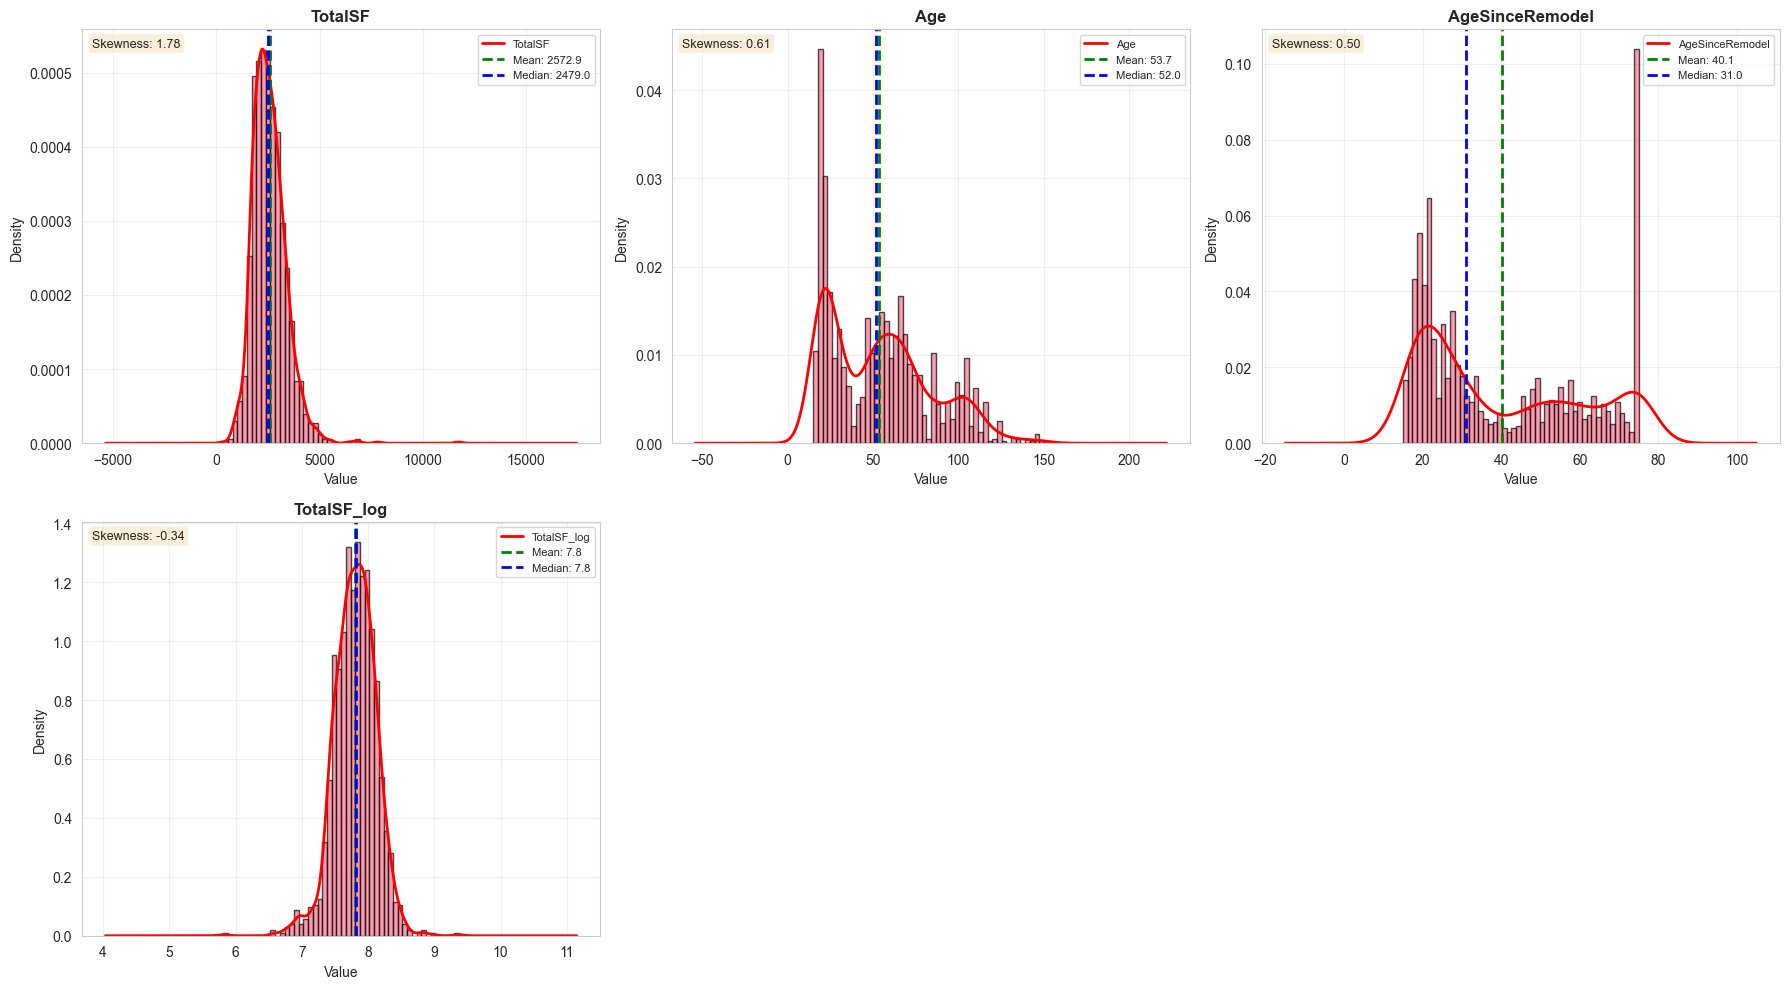


Summary Statistics for Newly Engineered Features:
--------------------------------------------------------------------------------

TotalSF:
  Mean: 2572.89
  Median: 2479.00
  Std Dev: 823.60
  Min: 334.00
  Max: 11752.00
  Skewness: 1.78

Age:
  Mean: 53.73
  Median: 52.00
  Std Dev: 30.20
  Min: 15.00
  Max: 153.00
  Skewness: 0.61

AgeSinceRemodel:
  Mean: 40.13
  Median: 31.00
  Std Dev: 20.65
  Min: 15.00
  Max: 75.00
  Skewness: 0.50

TotalSF_log:
  Mean: 7.81
  Median: 7.82
  Std Dev: 0.31
  Min: 5.81
  Max: 9.37
  Skewness: -0.34


In [247]:
# Visualize the newly created features
print("\n" + "=" * 80)
print("UNIVARIATE VISUALIZATIONS OF NEWLY ENGINEERED FEATURES")
print("=" * 80)

# Collect all new numeric features to visualize
new_numeric_features = []

# Add new composite features
if 'TotalSF' in df.columns:
    new_numeric_features.append('TotalSF')
if 'Age' in df.columns:
    new_numeric_features.append('Age')
if 'AgeSinceRemodel' in df.columns:
    new_numeric_features.append('AgeSinceRemodel')

# Add log-transformed features
for item in log_transformed:
    if item['New_Column'] in df.columns:
        new_numeric_features.append(item['New_Column'])

if len(new_numeric_features) > 0:
    print(f"\nVisualizing {len(new_numeric_features)} newly engineered numeric features...")
    
    # Create distribution plots
    n_features = len(new_numeric_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, feat in enumerate(new_numeric_features):
        if idx < len(axes) and feat in df.columns:
            # Histogram with KDE
            axes[idx].hist(df[feat].dropna(), bins=50, alpha=0.7, edgecolor='black', density=True)
            df[feat].dropna().plot.density(ax=axes[idx], color='red', linewidth=2)
            axes[idx].set_title(f'{feat}', fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Value', fontsize=10)
            axes[idx].set_ylabel('Density', fontsize=10)
            axes[idx].grid(True, alpha=0.3)
            
            # Add statistics
            mean_val = df[feat].mean()
            median_val = df[feat].median()
            skew_val = df[feat].skew()
            axes[idx].axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')
            axes[idx].axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}')
            axes[idx].legend(fontsize=8)
            axes[idx].text(0.02, 0.98, f'Skewness: {skew_val:.2f}', 
                          transform=axes[idx].transAxes, fontsize=9,
                          verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide extra subplots
    for idx in range(len(new_numeric_features), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nSummary Statistics for Newly Engineered Features:")
    print("-" * 80)
    for feat in new_numeric_features:
        if feat in df.columns:
            print(f"\n{feat}:")
            print(f"  Mean: {df[feat].mean():.2f}")
            print(f"  Median: {df[feat].median():.2f}")
            print(f"  Std Dev: {df[feat].std():.2f}")
            print(f"  Min: {df[feat].min():.2f}")
            print(f"  Max: {df[feat].max():.2f}")
            print(f"  Skewness: {df[feat].skew():.2f}")
else:
    print("\nNo new numeric features to visualize.")



Boxplots of Newly Engineered Features:
--------------------------------------------------------------------------------


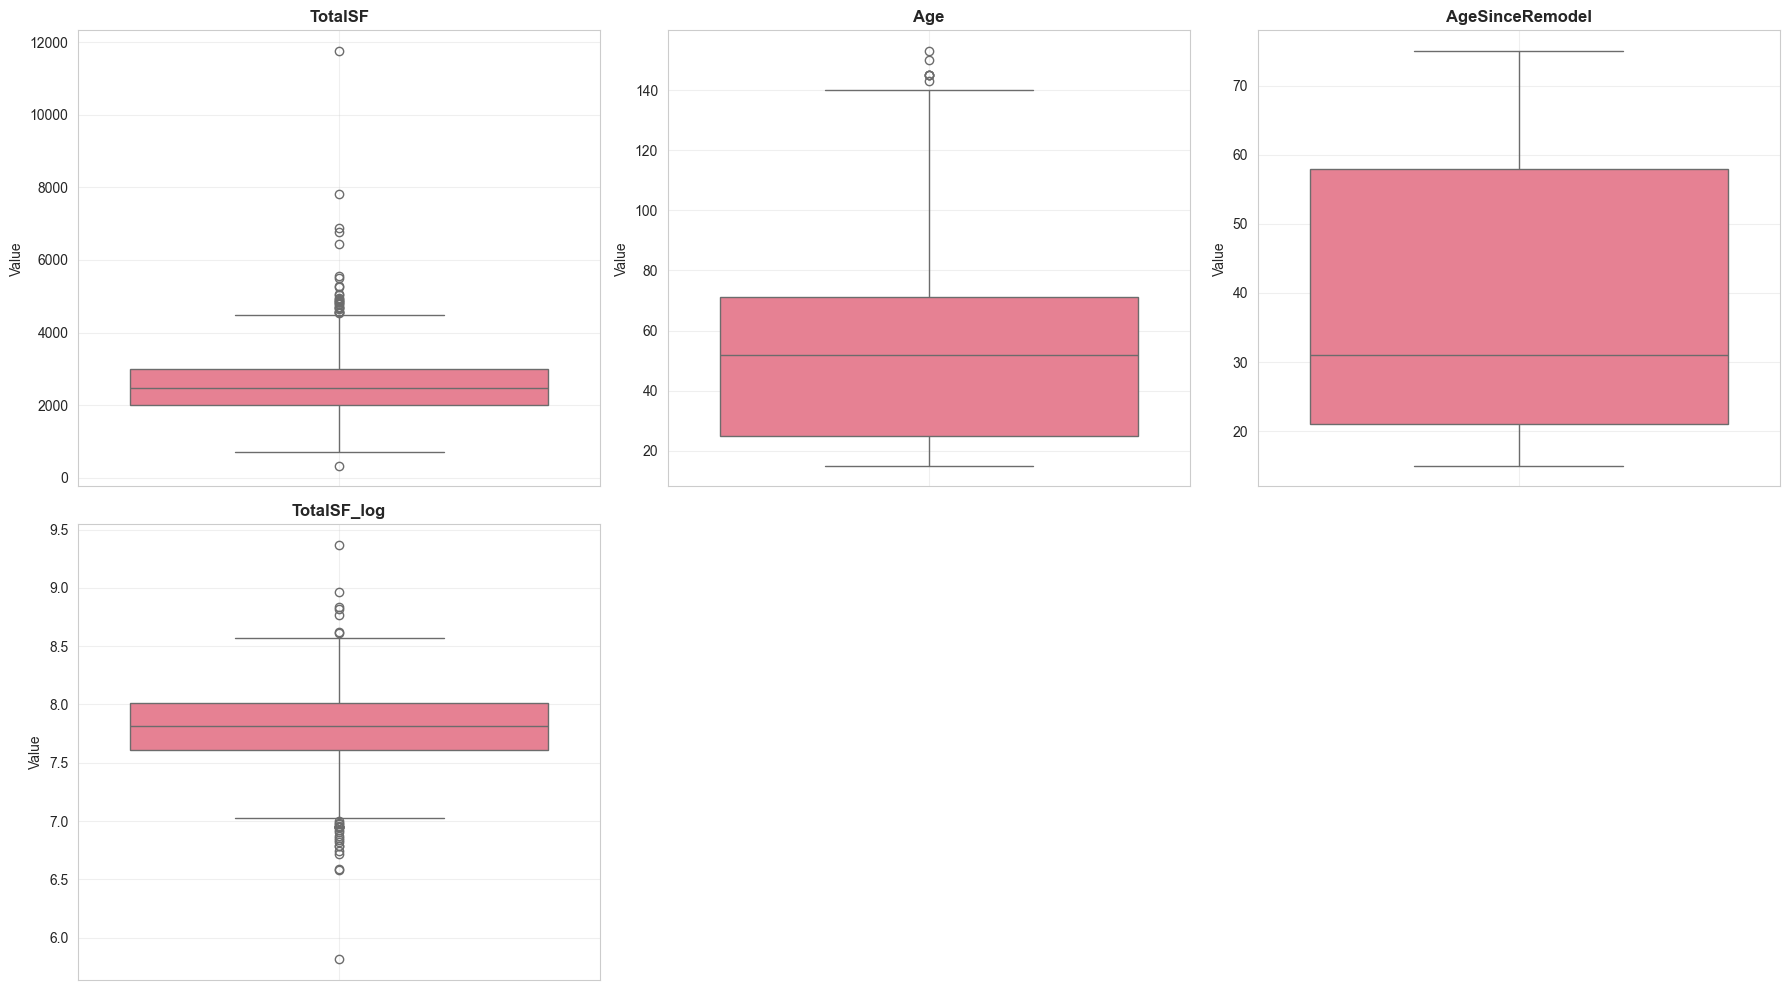


Outlier Analysis (values beyond 1.5×IQR):
--------------------------------------------------------------------------------
TotalSF                   Outliers:   28 ( 1.92%)
Age                       Outliers:    7 ( 0.48%)
TotalSF_log               Outliers:   31 ( 2.12%)


In [248]:
# Boxplots for newly engineered features
if len(new_numeric_features) > 0:
    print("\nBoxplots of Newly Engineered Features:")
    print("-" * 80)
    
    n_features = len(new_numeric_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, feat in enumerate(new_numeric_features):
        if idx < len(axes) and feat in df.columns:
            sns.boxplot(y=df[feat].dropna(), ax=axes[idx])
            axes[idx].set_title(f'{feat}', fontsize=12, fontweight='bold')
            axes[idx].set_ylabel('Value', fontsize=10)
            axes[idx].grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(new_numeric_features), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Identify outliers
    print("\nOutlier Analysis (values beyond 1.5×IQR):")
    print("-" * 80)
    for feat in new_numeric_features:
        if feat in df.columns:
            Q1 = df[feat].quantile(0.25)
            Q3 = df[feat].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[feat] < lower_bound) | (df[feat] > upper_bound)]
            if len(outliers) > 0:
                print(f"{feat:<25} Outliers: {len(outliers):>4} ({len(outliers)/len(df)*100:>5.2f}%)")



Relationship with LogSalePrice:
--------------------------------------------------------------------------------


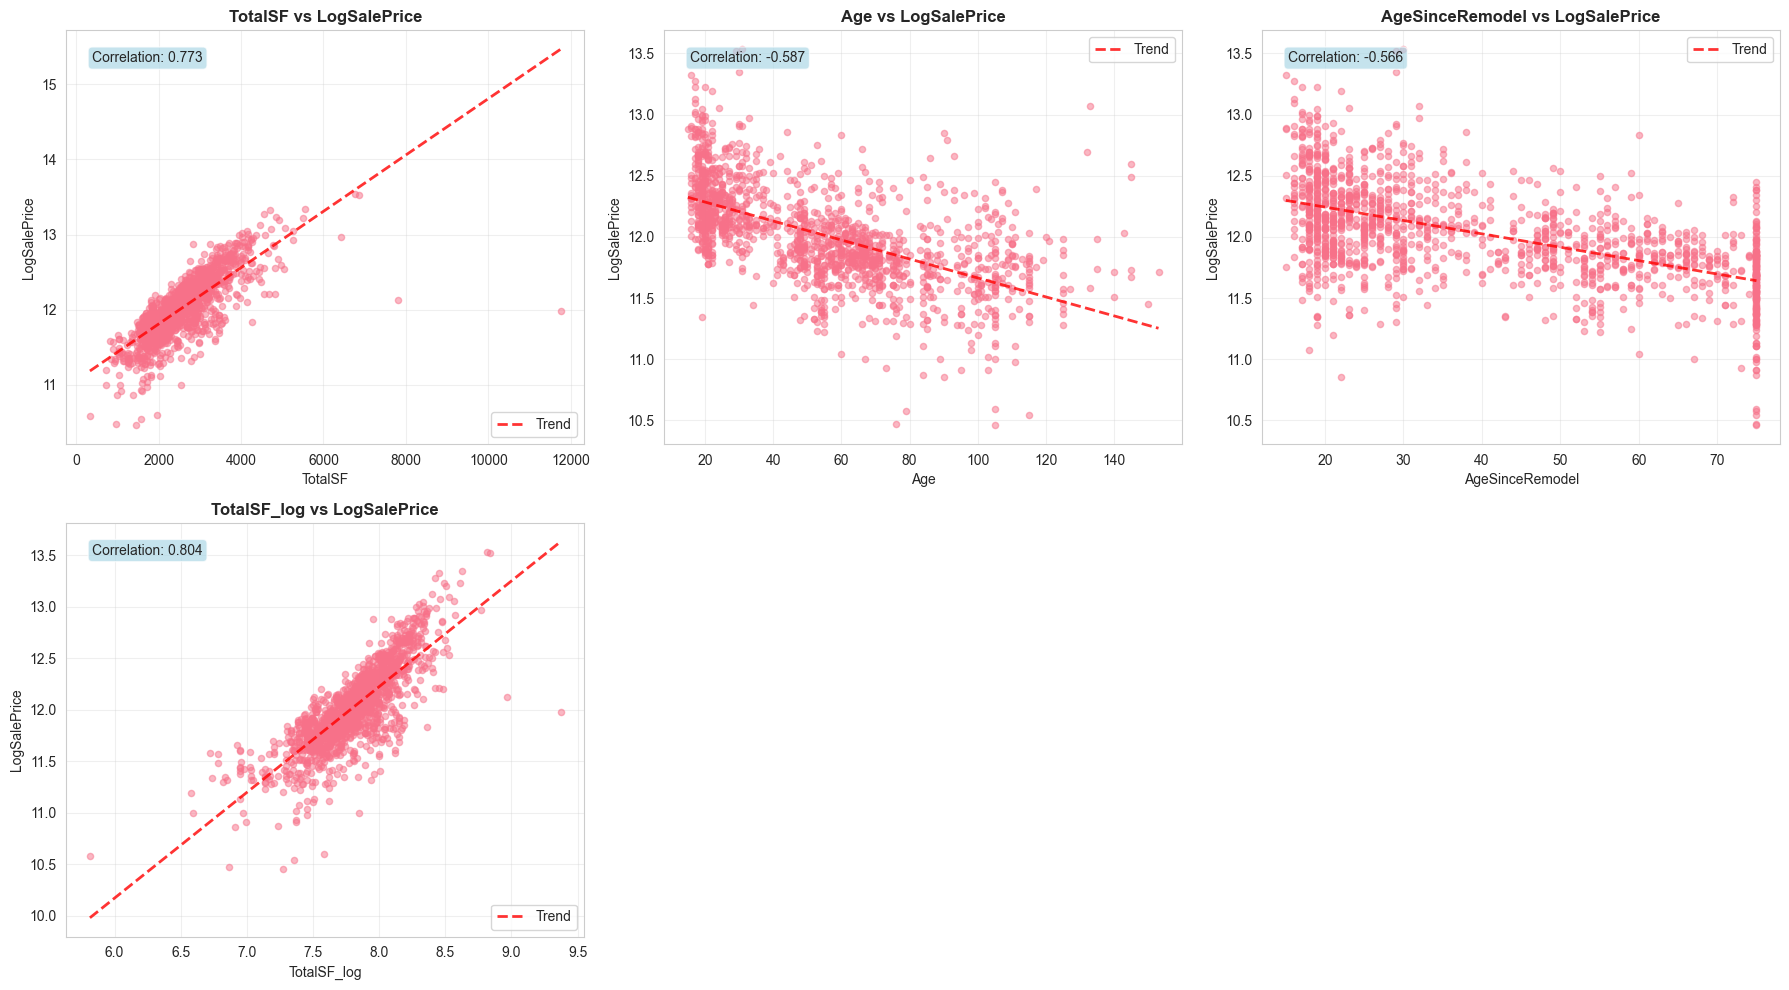


Correlations with LogSalePrice:
--------------------------------------------------------------------------------
TotalSF                   Correlation:  0.773
Age                       Correlation: -0.587
AgeSinceRemodel           Correlation: -0.566
TotalSF_log               Correlation:  0.804


In [249]:
# Scatterplots of new features vs LogSalePrice (to see relationships)
if len(new_numeric_features) > 0:
    print("\nRelationship with LogSalePrice:")
    print("-" * 80)
    
    n_features = len(new_numeric_features)
    n_cols = 3
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes
    
    for idx, feat in enumerate(new_numeric_features):
        if idx < len(axes) and feat in df.columns and 'LogSalePrice' in df.columns:
            # Scatter plot
            axes[idx].scatter(df[feat], df['LogSalePrice'], alpha=0.5, s=20)
            
            # Add trend line
            valid_mask = df[feat].notna() & df['LogSalePrice'].notna()
            if valid_mask.sum() > 1:
                z = np.polyfit(df.loc[valid_mask, feat], df.loc[valid_mask, 'LogSalePrice'], 1)
                p = np.poly1d(z)
                sorted_feat = df.loc[valid_mask, feat].sort_values()
                axes[idx].plot(sorted_feat, p(sorted_feat), 
                              "r--", alpha=0.8, linewidth=2, label='Trend')
                
                # Calculate correlation
                corr = df.loc[valid_mask, feat].corr(df.loc[valid_mask, 'LogSalePrice'])
                axes[idx].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                              transform=axes[idx].transAxes, fontsize=10,
                              verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
            
            axes[idx].set_xlabel(feat, fontsize=10)
            axes[idx].set_ylabel('LogSalePrice', fontsize=10)
            axes[idx].set_title(f'{feat} vs LogSalePrice', fontsize=12, fontweight='bold')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)
    
    # Hide extra subplots
    for idx in range(len(new_numeric_features), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print correlations
    print("\nCorrelations with LogSalePrice:")
    print("-" * 80)
    for feat in new_numeric_features:
        if feat in df.columns and 'LogSalePrice' in df.columns:
            valid_mask = df[feat].notna() & df['LogSalePrice'].notna()
            if valid_mask.sum() > 1:
                corr = df.loc[valid_mask, feat].corr(df.loc[valid_mask, 'LogSalePrice'])
                print(f"{feat:<25} Correlation: {corr:>6.3f}")


---

# SECTION 7 — DATA PREPROCESSING FOR MODEL TRAINING

This section prepares the data for machine learning models by encoding categorical variables and scaling features. Proper preprocessing is essential for model performance and convergence.


In [250]:
# Data Preprocessing for Model Training
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np

print("=" * 80)
print("DATA PREPROCESSING FOR MODEL TRAINING")
print("=" * 80)
print("\nThis section will:")
print("  1. Encode categorical variables (label encoding: categories → 1, 2, 3, ...)")
print("  2. Scale all features (standardization)")
print("  3. Prepare final feature matrix for model training")
print("=" * 80)


DATA PREPROCESSING FOR MODEL TRAINING

This section will:
  1. Encode categorical variables (label encoding: categories → 1, 2, 3, ...)
  2. Scale all features (standardization)
  3. Prepare final feature matrix for model training


## 1. Identify Feature Types


In [251]:
# Use recommended features from Section 2.5
print("\n" + "=" * 80)
print("USING RECOMMENDED FEATURES FROM SECTION 2.5")
print("=" * 80)

# Check if recommended_features exists
if 'recommended_features' not in globals():
    print("\n⚠ Warning: recommended_features not found. Please run Section 2.5 first.")
    print("Using all features as fallback...")
    # Fallback: use all features
    recommended_numeric = [col for col in df.select_dtypes(include=[np.number]).columns 
                          if col not in ['Id', 'SalePrice', 'LogSalePrice']]
    recommended_categorical = [col for col in df.select_dtypes(include=['object']).columns]
else:
    recommended_numeric = recommended_features.get('numeric', [])
    recommended_categorical = recommended_features.get('categorical', [])

print(f"\nRecommended features to preprocess:")
print(f"  Numeric features: {len(recommended_numeric)}")
print(f"  Categorical features: {len(recommended_categorical)}")
print(f"  Total: {len(recommended_numeric) + len(recommended_categorical)}")

# Verify features exist in dataframe
recommended_numeric = [f for f in recommended_numeric if f in df.columns]
recommended_categorical = [f for f in recommended_categorical if f in df.columns]

print(f"\nFeatures found in dataframe:")
print(f"  Numeric: {len(recommended_numeric)}")
print(f"  Categorical: {len(recommended_categorical)}")

# Debug: Check what categorical features actually exist in the dataframe
all_categorical_in_df = [col for col in df.select_dtypes(include=['object']).columns]
print(f"\nDebug info:")
print(f"  All categorical features in df: {len(all_categorical_in_df)}")
print(f"  Recommended categorical features: {recommended_categorical}")
if len(recommended_categorical) != len([f for f in recommended_categorical if f in all_categorical_in_df]):
    print(f"  ⚠ Warning: Some recommended categorical features may not be in dataframe!")

if len(recommended_numeric) > 0:
    print(f"\nNumeric features ({len(recommended_numeric)}):")
    for feat in sorted(recommended_numeric):
        print(f"  • {feat}")

if len(recommended_categorical) > 0:
    print(f"\nCategorical features ({len(recommended_categorical)}):")
    for feat in sorted(recommended_categorical):
        print(f"  • {feat}")



USING RECOMMENDED FEATURES FROM SECTION 2.5

Recommended features to preprocess:
  Numeric features: 8
  Categorical features: 10
  Total: 18

Features found in dataframe:
  Numeric: 8
  Categorical: 10

Debug info:
  All categorical features in df: 45
  Recommended categorical features: ['Neighborhood', 'KitchenQual', 'ExterQual', 'GarageFinish', 'BsmtQual', 'CentralAir', 'GarageType', 'FireplaceQu', 'Foundation', 'BsmtFinType1']

Numeric features (8):
  • Age
  • AgeSinceRemodel
  • FullBath
  • GarageArea
  • GarageCars
  • OverallQual
  • TotRmsAbvGrd
  • TotalSF

Categorical features (10):
  • BsmtFinType1
  • BsmtQual
  • CentralAir
  • ExterQual
  • FireplaceQu
  • Foundation
  • GarageFinish
  • GarageType
  • KitchenQual
  • Neighborhood


## 2. Encode Categorical Variables


In [252]:
# Apply label encoding to recommended categorical features
# Maps categories to numbers: 1, 2, 3, ... (one column per feature, not one-hot)
print("\n" + "=" * 80)
print("ENCODING CATEGORICAL VARIABLES (LABEL ENCODING)")
print("=" * 80)

# Create a copy of dataframe for preprocessing
df_processed = df.copy()

# Label encode recommended categorical features
label_encoders = {}  # Store encoders for potential use on test data
encoded_categorical_features = []  # Keep track of which features were encoded

if len(recommended_categorical) > 0:
    print(f"\nApplying label encoding to {len(recommended_categorical)} categorical features...")
    print(f"Features to encode: {recommended_categorical}")
    
    for col in recommended_categorical:
        if col in df_processed.columns:
            # Initialize label encoder
            le = LabelEncoder()
            
            # Fit and transform (maps categories to 0, 1, 2, ...)
            # Add 1 to start from 1 instead of 0 (as requested)
            encoded_values = le.fit_transform(df_processed[col].astype(str)) + 1
            
            # Replace the column with encoded values
            df_processed[col] = encoded_values
            
            # Store encoder for potential use on test data
            label_encoders[col] = le
            
            # Track encoded features
            encoded_categorical_features.append(col)
            
            # Show encoding mapping
            n_unique = len(le.classes_)
            print(f"  ✓ {col:<25} Encoded to 1-{n_unique} ({n_unique} unique categories)")
    
    print(f"\n✓ Label encoding complete")
    print(f"  Encoded {len(encoded_categorical_features)} categorical features")
    print(f"  Each feature remains as a single column with numeric values (1, 2, 3, ...)")
else:
    print("No categorical features to encode.")

# All features to use (numeric + label-encoded categorical)
# Categorical features are now numeric, so they're included in the numeric list
all_features_to_use = recommended_numeric + encoded_categorical_features

print(f"\nFeature summary after encoding:")
print(f"  Original numeric: {len(recommended_numeric)}")
print(f"  Label-encoded categorical: {len(encoded_categorical_features)}")
print(f"  Total features: {len(all_features_to_use)}")



ENCODING CATEGORICAL VARIABLES (LABEL ENCODING)

Applying label encoding to 10 categorical features...
Features to encode: ['Neighborhood', 'KitchenQual', 'ExterQual', 'GarageFinish', 'BsmtQual', 'CentralAir', 'GarageType', 'FireplaceQu', 'Foundation', 'BsmtFinType1']
  ✓ Neighborhood              Encoded to 1-25 (25 unique categories)
  ✓ KitchenQual               Encoded to 1-4 (4 unique categories)
  ✓ ExterQual                 Encoded to 1-4 (4 unique categories)
  ✓ GarageFinish              Encoded to 1-4 (4 unique categories)
  ✓ BsmtQual                  Encoded to 1-5 (5 unique categories)
  ✓ CentralAir                Encoded to 1-2 (2 unique categories)
  ✓ GarageType                Encoded to 1-7 (7 unique categories)
  ✓ FireplaceQu               Encoded to 1-6 (6 unique categories)
  ✓ Foundation                Encoded to 1-6 (6 unique categories)
  ✓ BsmtFinType1              Encoded to 1-7 (7 unique categories)

✓ Label encoding complete
  Encoded 10 categorical featur

## 3. Feature Scaling


In [253]:
# Apply standardization to all features (numeric + encoded categorical)
print("\n" + "=" * 80)
print("FEATURE SCALING (STANDARDIZATION)")
print("=" * 80)

print(f"\nScaling {len(all_features_to_use)} features...")
print(f"  Original numeric features: {len(recommended_numeric)}")
print(f"  Label-encoded categorical features: {len(encoded_categorical_features)}")
print(f"  Total features to scale: {len(all_features_to_use)}")

# Verify we have the right features
print(f"\nVerifying features to scale:")
print(f"  Recommended numeric features: {len(recommended_numeric)}")
print(f"  Label-encoded categorical features: {len(encoded_categorical_features)}")
print(f"  Total: {len(all_features_to_use)}")

# Initialize scaler
scaler = StandardScaler()

# Create feature matrix with only recommended features
# All features (numeric + label-encoded categorical) are now numeric
X_features = df_processed[all_features_to_use].copy()

# Verify we have exactly the features we want
assert len(X_features.columns) == len(all_features_to_use), \
    f"Mismatch: Expected {len(all_features_to_use)} features, got {len(X_features.columns)}"

# Ensure columns are in the right order
X_features = X_features[all_features_to_use]

# Fit scaler on training data
scaler.fit(X_features)

# Transform features
X_scaled = scaler.transform(X_features)
X_scaled_df = pd.DataFrame(X_scaled, columns=all_features_to_use, index=df_processed.index)

print(f"\n✓ Standardization complete")
print(f"  Scaled features: {len(all_features_to_use)}")
print(f"  Mean after scaling (should be ~0): {X_scaled_df.mean().mean():.6f}")
print(f"  Std after scaling (should be ~1): {X_scaled_df.std().mean():.6f}")

# Store scaler for later use (e.g., on test data)
print(f"\n✓ Scaler fitted and stored for use on test data")



FEATURE SCALING (STANDARDIZATION)

Scaling 18 features...
  Original numeric features: 8
  Label-encoded categorical features: 10
  Total features to scale: 18

Verifying features to scale:
  Recommended numeric features: 8
  Label-encoded categorical features: 10
  Total: 18

✓ Standardization complete
  Scaled features: 18
  Mean after scaling (should be ~0): -0.000000
  Std after scaling (should be ~1): 1.000343

✓ Scaler fitted and stored for use on test data


## 4. Prepare Final Feature Matrix


In [ ]:
# Prepare final feature matrix and target variable
print("\n" + "=" * 80)
print("FINAL FEATURE MATRIX PREPARATION")
print("=" * 80)

# Use scaled features
X = X_scaled_df

# Target variable (use LogSalePrice for modeling)
y = df['LogSalePrice']

print(f"\nFinal dataset shape:")
print(f"  Features (X): {X.shape[0]} samples × {X.shape[1]} features")
print(f"  Target (y): {y.shape[0]} samples")

print(f"\nFeature breakdown:")
print(f"  Original numeric features: {len(recommended_numeric)}")
print(f"  Label-encoded categorical features: {len(encoded_categorical_features)}")
print(f"  Total features: {len(all_features_to_use)}")

# Check for any remaining missing values
missing_count = X.isnull().sum().sum()
if missing_count > 0:
    print(f"\n⚠ Warning: {missing_count} missing values found in feature matrix")
    missing_features = X.columns[X.isnull().any()].tolist()
    for feat in missing_features[:5]:
        missing_val = X[feat].isnull().sum()
        print(f"    {feat}: {missing_val}")
    if len(missing_features) > 5:
        print(f"    ... and {len(missing_features) - 5} more")
else:
    print(f"\n✓ No missing values in feature matrix")

print("\n" + "=" * 80)
print("✓ Data preprocessing complete! Ready for model training.")
print("=" * 80)
print(f"\nAvailable variables:")
print(f"  • X: Preprocessed feature matrix ({X.shape[0]} samples × {X.shape[1]} features)")
print(f"  • y: Target variable - LogSalePrice ({y.shape[0]} samples)")
print(f"  • scaler: Fitted StandardScaler (for use on test data)")
print(f"  • all_features_to_use: List of {len(all_features_to_use)} feature names")

# Save preprocessed data for use in other notebooks
import joblib
import os

print(f"\n" + "=" * 80)
print("SAVING PREPROCESSED DATA")
print("=" * 80)

# Create directory for saved models/data if it doesn't exist
os.makedirs('saved_data', exist_ok=True)

# Save feature matrix and target (preserve index for split indices)
X.to_csv('saved_data/X_preprocessed.csv', index=True)
y.to_csv('saved_data/y_preprocessed.csv', index=True)
print("✓ Saved X and y to CSV files (with indices)")

# Save scaler using joblib (better for sklearn objects)
joblib.dump(scaler, 'saved_data/scaler.pkl')
print("✓ Saved scaler to joblib file")

# Save feature names list
import json
with open('saved_data/feature_names.json', 'w') as f:
    json.dump(all_features_to_use, f)
print("✓ Saved feature names list")

# Save label encoders for use on test data
if len(label_encoders) > 0:
    joblib.dump(label_encoders, 'saved_data/label_encoders.pkl')
    print("✓ Saved label encoders for categorical features")

print(f"\nSaved files:")
print(f"  • saved_data/X_preprocessed.csv - Feature matrix")
print(f"  • saved_data/y_preprocessed.csv - Target variable")
print(f"  • saved_data/scaler.pkl - Fitted StandardScaler")
print(f"  • saved_data/feature_names.json - Feature names list")
if len(label_encoders) > 0:
    print(f"  • saved_data/label_encoders.pkl - Label encoders for categorical features")
print(f"\n✓ All preprocessed data saved! You can now load these in other notebooks.")



FINAL FEATURE MATRIX PREPARATION

Final dataset shape:
  Features (X): 1460 samples × 18 features
  Target (y): 1460 samples

Feature breakdown:
  Original numeric features: 8
  Label-encoded categorical features: 10
  Total features: 18

✓ No missing values in feature matrix

✓ Data preprocessing complete! Ready for model training.

Available variables:
  • X: Preprocessed feature matrix (1460 samples × 18 features)
  • y: Target variable - LogSalePrice (1460 samples)
  • scaler: Fitted StandardScaler (for use on test data)
  • all_features_to_use: List of 18 feature names

SAVING PREPROCESSED DATA
✓ Saved X and y to CSV files
✓ Saved scaler to joblib file
✓ Saved feature names list
✓ Saved label encoders for categorical features

Saved files:
  • saved_data/X_preprocessed.csv - Feature matrix
  • saved_data/y_preprocessed.csv - Target variable
  • saved_data/scaler.pkl - Fitted StandardScaler
  • saved_data/feature_names.json - Feature names list
  • saved_data/label_encoders.pkl - 

## 5. Create and Save Train/Val/Test Split Indices


In [ ]:
# Create train/val/test split indices for consistent use across all model notebooks
from sklearn.model_selection import train_test_split

print("\n" + "=" * 80)
print("CREATING TRAIN/VAL/TEST SPLIT INDICES")
print("=" * 80)

# Use the same random state for reproducibility
random_state = 42

# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=random_state
)

# Second split: separate train (60%) and validation (20%) from remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,  # 25% of 80% = 20% of total
    random_state=random_state
)

print(f"\nSplit sizes:")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation set: {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Save split indices (row indices from original dataframe)
split_indices = {
    'train': X_train.index.tolist(),
    'val': X_val.index.tolist(),
    'test': X_test.index.tolist(),
    'random_state': random_state
}

with open('saved_data/split_indices.json', 'w') as f:
    json.dump(split_indices, f)

print(f"\n✓ Split indices saved to saved_data/split_indices.json")
print(f"  All model notebooks can use these same splits for fair comparison")
print(f"  Random state: {random_state} (for reproducibility)")
